<a href="https://colab.research.google.com/github/MIARD/SMC/blob/main/SMC_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import joblib
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tabulate import tabulate

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_main = pd.read_excel('SSL_T.xlsx')
# df = pd.read_excel('SSL_T_MR.xlsx')
# df = pd.read_excel('SSL_M.xlsx')

# df = pd.read_excel('Train.xlsx')
# df = pd.read_excel('Test.xlsx')
# df = pd.read_excel('Train_Test.xlsx')

pd.set_option('display.max_rows', None)

#Creating Train Data Functions

In [ ]:
def calculate_metrics(group_df):
    total_trades = len(group_df)
    if total_trades == 0:
        return 0, 0, 0.0  # Trade Count, Profit/Loss, Win Rate

    total_pl = group_df['Profit/Loss'].sum()
    total_wins = (group_df['Profit/Loss'] > 0).sum()
    win_rate = total_wins / total_trades

    return total_trades, total_pl, win_rate


In [ ]:
def get_precomputed_stats(df):
    # Pre-calculate all possible feature combinations
    unique_15min = df['15Min'].unique()
    unique_hours = df['Hour'].unique()
    unique_weekdays = df['Start_Weekday'].unique()
    unique_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    unique_criteria = df['Criteria'].unique()

    # Extract Day of Month and Week of Month
    df['Day_of_Month'] = df['startDateTime'].dt.day
    df['Week_of_Month'] = df['startDateTime'].apply(lambda x: (x.day - 1) // 7 + 1)
    unique_day_of_month = df['Day_of_Month'].unique()
    unique_week_of_month = df['Week_of_Month'].unique()

    # Store pre-calculated statistics in a dictionary for efficient lookup
    precomputed_stats = {}

    # Calculate stats for each individual feature value
    for time_15min in unique_15min:
        df_15min = df[df['15Min'] == time_15min]
        stats = calculate_metrics(df_15min)
        precomputed_stats[('15Min', time_15min)] = stats

    for hour in unique_hours:
        df_hour = df[df['Hour'] == hour]
        stats = calculate_metrics(df_hour)
        precomputed_stats[('Hour', hour)] = stats

    for weekday in unique_weekdays:
        df_weekday = df[df['Start_Weekday'] == weekday]
        stats = calculate_metrics(df_weekday)
        precomputed_stats[('Weekday', weekday)] = stats

    for month in unique_months:
        df_month = df[df['Month'] == month]
        stats = calculate_metrics(df_month)
        precomputed_stats[('Month', month)] = stats

    for criteria in unique_criteria:
        df_criteria = df[df['Criteria'] == criteria]
        stats = calculate_metrics(df_criteria)
        precomputed_stats[('Criteria', criteria)] = stats

    # Calculate stats for Day of Month
    for day in unique_day_of_month:
        df_day = df[df['Day_of_Month'] == day]
        stats = calculate_metrics(df_day)
        precomputed_stats[('Day_of_Month', day)] = stats

    # Calculate stats for Week of Month
    for week in unique_week_of_month:
        df_week = df[df['Week_of_Month'] == week]
        stats = calculate_metrics(df_week)
        precomputed_stats[('Week_of_Month', week)] = stats


    # Calculate stats for combined features
    for weekday in unique_weekdays:
        for time_15min in unique_15min:
            df_weekday_15m = df[(df['Start_Weekday'] == weekday) & (df['15Min'] == time_15min)]
            stats = calculate_metrics(df_weekday_15m)
            precomputed_stats[('Weekday_15Min', weekday, time_15min)] = stats

        for hour in unique_hours:
            df_weekday_hour = df[(df['Start_Weekday'] == weekday) & (df['Hour'] == hour)]
            stats = calculate_metrics(df_weekday_hour)
            precomputed_stats[('Weekday_Hour', weekday, hour)] = stats

        for month in unique_months:
            df_weekday_month = df[(df['Start_Weekday'] == weekday) & (df['Month'] == month)]
            stats = calculate_metrics(df_weekday_month)
            precomputed_stats[('Weekday_Month', weekday, month)] = stats

        for day in unique_day_of_month:
            df_weekday_day = df[(df['Start_Weekday'] == weekday) & (df['Day_of_Month'] == day)]
            stats = calculate_metrics(df_weekday_day)
            precomputed_stats[('Weekday_Day', weekday, day)] = stats

        for week in unique_week_of_month:
            df_weekday_week = df[(df['Start_Weekday'] == weekday) & (df['Week_of_Month'] == week)]
            stats = calculate_metrics(df_weekday_week)
            precomputed_stats[('Weekday_Week', weekday, week)] = stats


    for criteria in unique_criteria:
        for time_15min in unique_15min:
            df_criteria_15m = df[(df['Criteria'] == criteria) & (df['15Min'] == time_15min)]
            stats = calculate_metrics(df_criteria_15m)
            precomputed_stats[('Criteria_15Min', criteria, time_15min)] = stats

        for hour in unique_hours:
            df_criteria_hour = df[(df['Criteria'] == criteria) & (df['Hour'] == hour)]
            stats = calculate_metrics(df_criteria_hour)
            precomputed_stats[('Criteria_Hour', criteria, hour)] = stats

        for weekday in unique_weekdays:
            df_criteria_weekday = df[(df['Criteria'] == criteria) & (df['Start_Weekday'] == weekday)]
            stats = calculate_metrics(df_criteria_weekday)
            precomputed_stats[('Criteria_Weekday', criteria, weekday)] = stats

        for month in unique_months:
            df_criteria_month = df[(df['Criteria'] == criteria) & (df['Month'] == month)]
            stats = calculate_metrics(df_criteria_month)
            precomputed_stats[('Criteria_Month', criteria, month)] = stats

        for day in unique_day_of_month:
            df_criteria_day = df[(df['Criteria'] == criteria) & (df['Day_of_Month'] == day)]
            stats = calculate_metrics(df_criteria_day)
            precomputed_stats[('Criteria_Day', criteria, day)] = stats

        for week in unique_week_of_month:
            df_criteria_week = df[(df['Criteria'] == criteria) & (df['Week_of_Month'] == week)]
            stats = calculate_metrics(df_criteria_week)
            precomputed_stats[('Criteria_Week', criteria, week)] = stats


    for hour in unique_hours:
        for month in unique_months:
            df_hour_month = df[(df['Hour'] == hour) & (df['Month'] == month)]
            stats = calculate_metrics(df_hour_month)
            precomputed_stats[('Hour_Month', hour, month)] = stats

        for day in unique_day_of_month:
            df_hour_day = df[(df['Hour'] == hour) & (df['Day_of_Month'] == day)]
            stats = calculate_metrics(df_hour_day)
            precomputed_stats[('Hour_Day', hour, day)] = stats

        for week in unique_week_of_month:
            df_hour_week = df[(df['Hour'] == hour) & (df['Week_of_Month'] == week)]
            stats = calculate_metrics(df_hour_week)
            precomputed_stats[('Hour_Week', hour, week)] = stats


    for time_15min in unique_15min:
        for month in unique_months:
            df_15min_month = df[(df['15Min'] == time_15min) & (df['Month'] == month)]
            stats = calculate_metrics(df_15min_month)
            precomputed_stats[('15Min_Month', time_15min, month)] = stats

        for day in unique_day_of_month:
            df_15min_day = df[(df['15Min'] == time_15min) & (df['Day_of_Month'] == day)]
            stats = calculate_metrics(df_15min_day)
            precomputed_stats[('15Min_Day', time_15min, day)] = stats

        for week in unique_week_of_month:
            df_15min_week = df[(df['15Min'] == time_15min) & (df['Week_of_Month'] == week)]
            stats = calculate_metrics(df_15min_week)
            precomputed_stats[('15Min_Week', time_15min, week)] = stats


    for month in unique_months:
        for day in unique_day_of_month:
            df_month_day = df[(df['Month'] == month) & (df['Day_of_Month'] == day)]
            stats = calculate_metrics(df_month_day)
            precomputed_stats[('Month_Day', month, day)] = stats

        for week in unique_week_of_month:
            df_month_week = df[(df['Month'] == month) & (df['Week_of_Month'] == week)]
            stats = calculate_metrics(df_month_week)
            precomputed_stats[('Month_Week', month, week)] = stats

    for day in unique_day_of_month:
        for week in unique_week_of_month:
            df_day_week = df[(df['Day_of_Month'] == day) & (df['Week_of_Month'] == week)]
            stats = calculate_metrics(df_day_week)
            precomputed_stats[('Day_Week', day, week)] = stats

    return precomputed_stats


In [ ]:
def get_feature_data(precomputed_stats, index, row):
    # Retrieve stats for individual features
    row_data = {}
    time_15min = row['15Min']
    trade_count_15m, pl_15m, win_rate_15m = precomputed_stats[('15Min', time_15min)]
    row_data['15Min_Trade Count'] = trade_count_15m
    row_data['15Min_Win Rate'] = win_rate_15m
    row_data['15Min_Profit/Loss'] = pl_15m

    hour = row['Hour']
    trade_count_hour, pl_hour, win_rate_hour = precomputed_stats[('Hour', hour)]
    row_data['Hour_Trade Count'] = trade_count_hour
    row_data['Hour_Win Rate'] = win_rate_hour
    row_data['Hour_Profit/Loss'] = pl_hour

    weekday = row['Start_Weekday']
    trade_count_weekday, pl_weekday, win_rate_weekday = precomputed_stats[('Weekday', weekday)]
    row_data['Weekday_Trade Count'] = trade_count_weekday
    row_data['Weekday_Win Rate'] = win_rate_weekday
    row_data['Weekday_Profit/Loss'] = pl_weekday

    month = row['Month']
    trade_count_month, pl_month, win_rate_month = precomputed_stats[('Month', month)]
    row_data['Month_Trade Count'] = trade_count_month
    row_data['Month_Win Rate'] = win_rate_month
    row_data['Month_Profit/Loss'] = pl_month

    criteria = row['Criteria']
    trade_count_criteria, pl_criteria, win_rate_criteria = precomputed_stats[('Criteria', criteria)]
    row_data['Criteria_Trade Count'] = trade_count_criteria
    row_data['Criteria_Win Rate'] = win_rate_criteria
    row_data['Criteria_Profit/Loss'] = pl_criteria

    # Add features for Day of Month and Week of Month
    day_of_month = row['Day_of_Month']
    trade_count_day, pl_day, win_rate_day = precomputed_stats[('Day_of_Month', day_of_month)]
    row_data['Day_of_Month_Trade Count'] = trade_count_day
    row_data['Day_of_Month_Win Rate'] = win_rate_day
    row_data['Day_of_Month_Profit/Loss'] = pl_day

    week_of_month = row['Week_of_Month']
    trade_count_week, pl_week, win_rate_week = precomputed_stats[('Week_of_Month', week_of_month)]
    row_data['Week_of_Month_Trade Count'] = trade_count_week
    row_data['Week_of_Month_Win Rate'] = win_rate_week
    row_data['Week_of_Month_Profit/Loss'] = pl_week

    # Retrieve stats for combined features
    trade_count_weekday_15m, pl_weekday_15m, win_rate_weekday_15m = precomputed_stats[('Weekday_15Min', weekday, time_15min)]
    row_data['Weekday_15Min_Trade Count'] = trade_count_weekday_15m
    row_data['Weekday_15Min_Win Rate'] = win_rate_weekday_15m
    row_data['Weekday_15Min_Profit/Loss'] = pl_weekday_15m

    trade_count_weekday_hour, pl_weekday_hour, win_rate_weekday_hour = precomputed_stats[('Weekday_Hour', weekday, hour)]
    row_data['Weekday_Hour_Trade Count'] = trade_count_weekday_hour
    row_data['Weekday_Hour_Win Rate'] = win_rate_weekday_hour
    row_data['Weekday_Hour_Profit/Loss'] = pl_weekday_hour

    trade_count_weekday_month, pl_weekday_month, win_rate_weekday_month = precomputed_stats[('Weekday_Month', weekday, month)]
    row_data['Weekday_Month_Trade Count'] = trade_count_weekday_month
    row_data['Weekday_Month_Win Rate'] = win_rate_weekday_month
    row_data['Weekday_Month_Profit/Loss'] = pl_weekday_month

    trade_count_criteria_15m, pl_criteria_15m, win_rate_criteria_15m = precomputed_stats[('Criteria_15Min', criteria, time_15min)]
    row_data['Criteria_15Min_Trade Count'] = trade_count_criteria_15m
    row_data['Criteria_15Min_Win Rate'] = win_rate_criteria_15m
    row_data['Criteria_15Min_Profit/Loss'] = pl_criteria_15m

    trade_count_criteria_hour, pl_criteria_hour, win_rate_criteria_hour = precomputed_stats[('Criteria_Hour', criteria, hour)]
    row_data['Criteria_Hour_Trade Count'] = trade_count_criteria_hour
    row_data['Criteria_Hour_Win Rate'] = win_rate_criteria_hour
    row_data['Criteria_Hour_Profit/Loss'] = pl_criteria_hour

    trade_count_criteria_weekday, pl_criteria_weekday, win_rate_criteria_weekday = precomputed_stats[('Criteria_Weekday', criteria, weekday)]
    row_data['Criteria_Weekday_Trade Count'] = trade_count_criteria_weekday
    row_data['Criteria_Weekday_Win Rate'] = win_rate_criteria_weekday
    row_data['Criteria_Weekday_Profit/Loss'] = pl_criteria_weekday

    trade_count_criteria_month, pl_criteria_month, win_rate_criteria_month = precomputed_stats[('Criteria_Month', criteria, month)]
    row_data['Criteria_Month_Trade Count'] = trade_count_criteria_month
    row_data['Criteria_Month_Win Rate'] = win_rate_criteria_month
    row_data['Criteria_Month_Profit/Loss'] = pl_criteria_month

    trade_count_hour_month, pl_hour_month, win_rate_hour_month = precomputed_stats[('Hour_Month', hour, month)]
    row_data['Hour_Month_Trade Count'] = trade_count_hour_month
    row_data['Hour_Month_Win Rate'] = win_rate_hour_month
    row_data['Hour_Month_Profit/Loss'] = pl_hour_month

    trade_count_15min_month, pl_15min_month, win_rate_15min_month = precomputed_stats[('15Min_Month', time_15min, month)]
    row_data['15Min_Month_Trade Count'] = trade_count_15min_month
    row_data['15Min_Month_Win Rate'] = win_rate_15min_month
    row_data['15Min_Month_Profit/Loss'] = pl_15min_month

    # Add combined features for Day of Month and Week of Month
    trade_count_weekday_day, pl_weekday_day, win_rate_weekday_day = precomputed_stats[('Weekday_Day', weekday, day_of_month)]
    row_data['Weekday_Day_Trade Count'] = trade_count_weekday_day
    row_data['Weekday_Day_Win Rate'] = win_rate_weekday_day
    row_data['Weekday_Day_Profit/Loss'] = pl_weekday_day

    trade_count_weekday_week, pl_weekday_week, win_rate_weekday_week = precomputed_stats[('Weekday_Week', weekday, week_of_month)]
    row_data['Weekday_Week_Trade Count'] = trade_count_weekday_week
    row_data['Weekday_Week_Win Rate'] = win_rate_weekday_week
    row_data['Weekday_Week_Profit/Loss'] = pl_weekday_week

    trade_count_criteria_day, pl_criteria_day, win_rate_criteria_day = precomputed_stats[('Criteria_Day', criteria, day_of_month)]
    row_data['Criteria_Day_Trade Count'] = trade_count_criteria_day
    row_data['Criteria_Day_Win Rate'] = win_rate_criteria_day
    row_data['Criteria_Day_Profit/Loss'] = pl_criteria_day

    trade_count_criteria_week, pl_criteria_week, win_rate_criteria_week = precomputed_stats[('Criteria_Week', criteria, week_of_month)]
    row_data['Criteria_Week_Trade Count'] = trade_count_criteria_week
    row_data['Criteria_Week_Win Rate'] = win_rate_criteria_week
    row_data['Criteria_Week_Profit/Loss'] = pl_criteria_week

    trade_count_hour_day, pl_hour_day, win_rate_hour_day = precomputed_stats[('Hour_Day', hour, day_of_month)]
    row_data['Hour_Day_Trade Count'] = trade_count_hour_day
    row_data['Hour_Day_Win Rate'] = win_rate_hour_day
    row_data['Hour_Day_Profit/Loss'] = pl_hour_day

    trade_count_hour_week, pl_hour_week, win_rate_hour_week = precomputed_stats[('Hour_Week', hour, week_of_month)]
    row_data['Hour_Week_Trade Count'] = trade_count_hour_week
    row_data['Hour_Week_Win Rate'] = win_rate_hour_week
    row_data['Hour_Week_Profit/Loss'] = pl_hour_week

    trade_count_15min_day, pl_15min_day, win_rate_15min_day = precomputed_stats[('15Min_Day', time_15min, day_of_month)]
    row_data['15Min_Day_Trade Count'] = trade_count_15min_day
    row_data['15Min_Day_Win Rate'] = win_rate_15min_day
    row_data['15Min_Day_Profit/Loss'] = pl_15min_day

    trade_count_15min_week, pl_15min_week, win_rate_15min_week = precomputed_stats[('15Min_Week', time_15min, week_of_month)]
    row_data['15Min_Week_Trade Count'] = trade_count_15min_week
    row_data['15Min_Week_Win Rate'] = win_rate_15min_week
    row_data['15Min_Week_Profit/Loss'] = pl_15min_week

    trade_count_month_day, pl_month_day, win_rate_month_day = precomputed_stats[('Month_Day', month, day_of_month)]
    row_data['Month_Day_Trade Count'] = trade_count_month_day
    row_data['Month_Day_Win Rate'] = win_rate_month_day
    row_data['Month_Day_Profit/Loss'] = pl_month_day

    trade_count_month_week, pl_month_week, win_rate_month_week = precomputed_stats[('Month_Week', month, week_of_month)]
    row_data['Month_Week_Trade Count'] = trade_count_month_week
    row_data['Month_Week_Win Rate'] = win_rate_month_week
    row_data['Month_Week_Profit/Loss'] = pl_month_week

    trade_count_day_week, pl_day_week, win_rate_day_week = precomputed_stats[('Day_Week', day_of_month, week_of_month)]
    row_data['Day_Week_Trade Count'] = trade_count_day_week
    row_data['Day_Week_Win Rate'] = win_rate_day_week
    row_data['Day_Week_Profit/Loss'] = pl_day_week

    return row_data

In [ ]:
def get_train_data(df, precomputed_stats):
    # Prepare an empty DataFrame to store the results for each row
    train_data_list = []

    # Iterate through each row of the original DataFrame
    for index, row in df.iterrows():
        row_data = get_feature_data(precomputed_stats, index, row)
        train_data_list.append(row_data)

    # Create the new DataFrame
    train_data = pd.DataFrame(train_data_list)
    # train_data will now contain the calculated statistics for each row of the original df
    # You can merge this back with the original df if needed:
    # train_data = pd.concat([df.reset_index(drop=True), train_data], axis=1)
    return train_data

###Get Train Data From Input

In [ ]:
def get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols):

    # Convert inputs
    try:
        input_time = datetime.strptime(time_input, '%H:%M').time()
    except ValueError:
        print("Invalid time format. Use HH:MM.")
        return pd.DataFrame()

    try:
        input_date = datetime.strptime(date_input, '%m/%d/%Y')
    except ValueError:
        print("Invalid date format. Use M/D/YYYY.")
        return pd.DataFrame()

    row_data = {}
    input_datetime = datetime.combine(input_date, input_time)
    time_15min = input_datetime.strftime('%H:%M')
    hour = input_datetime.hour
    weekday = input_datetime.strftime('%A')
    month = input_datetime.strftime('%B')
    criteria = criteria_input
    day_of_month = input_datetime.day
    week_of_month = (input_datetime.day - 1) // 7 + 1

    # Retrieve stats from precomputed_stats dictionary
    try:
        row = {'15Min': time_15min, 'Hour': hour, 'Start_Weekday': weekday, 'Month': month, 'Criteria': criteria, 'Day_of_Month':day_of_month, 'Week_of_Month':week_of_month}
        row_data = get_feature_data(precomputed_stats, 0, row)

    except KeyError as e:
        print(f"Error: Missing precomputed statistic for key {e}. Ensure create_precomputed_stats covers all combinations you need.")
        return pd.DataFrame()


    # Create DataFrame from the calculated row_data
    input_features_df = pd.DataFrame([row_data])
    # Reindex the input_features_df to match the training columns, filling missing with 0
    input_features_df = input_features_df.reindex(columns=training_feature_cols, fill_value=0)

    # Convert all columns to the same data type as the training features (assuming int from previous steps)
    # for col in input_features_df.columns:
    #     try:
    #          input_features_df[col] = pd.to_numeric(input_features_df[col], errors='coerce')
    #          input_features_df[col] = input_features_df[col].fillna(0).astype(int)
    #     except ValueError:
    #         print(f"Warning: Could not convert input column '{col}' to integer.")


    return input_features_df


# Call the optimized function
# input_data = get_train_data_for_input_optimized(precomputed_stats, '09:30', '01/8/2023', 'ELC', training_feature_cols)
# print(input_data)


#Test(Predicted) Data Analysis Functions

In [ ]:
def predict_trade_result(model, input_features_df, training_feature_cols):

    if input_features_df.empty:
        print("Cannot predict: Invalid input features.")
        return None, None

    # Make prediction
    input_features_df = input_features_df[training_feature_cols]
    predicted_class = model.predict(input_features_df)[0]
    if predicted_class == 0:
        predicted_proba = model.predict_proba(input_features_df)
    else:
        predicted_proba = model.predict_proba(input_features_df)

    return predicted_class, predicted_proba

#Stats & Visualizations Functions

In [172]:
def plot_confusion_matrices_horizontal(y_true, predictions, model_names, ticks= ['LOSS', 'WIN']):
    """
    Plots confusion matrices for multiple models horizontally with accuracy scores.

    Args:
        y_true (array-like): True labels.
        predictions (list of array-like): List of prediction arrays from each model.
        model_names (list of str): List of names for each model.
    """

    num_models = len(predictions)
    if num_models == 0 or len(predictions) != len(model_names):
        print("Invalid input for plotting confusion matrices.")
        return

    fig, axes = plt.subplots(2, int(num_models/2)+1, figsize=(5 * int(num_models/2) + 1, 6))
    if num_models == 1:
        axes = [axes] # Ensure axes is iterable even for one model
    r = 0
    for i, y_pred in enumerate(predictions):
        p_txt=""
        t_txt=""
        if i == 3:
          r =1
        if len(ticks) >2:
          ticks_u = np.union1d(y_true, y_pred)
          diff = np.setdiff1d(ticks , ticks_u)
          if len(ticks_u) != 0:
            p_txt = f"Missingn Classes: {np.setdiff1d(ticks, y_pred).tolist()}"
            t_txt = f"Missing Classes: {np.setdiff1d(ticks, y_true).tolist()}"
            ticks = ticks_u


        cm = confusion_matrix(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[r][i%3], cbar=False)
        axes[r, i%3].set_title(f'{model_names[i]}\nAccuracy: {accuracy:.2f}', fontsize=11)
        axes[r, i%3].set_xlabel(f'Predicted Label {p_txt}', fontsize=10)
        axes[r, i%3].set_ylabel(f'True Label {t_txt}', fontsize=10)
        axes[r, i%3].set_xticklabels(ticks)
        axes[r, i%3].set_yticklabels(ticks)

    plt.tight_layout()
    plt.show()




##Show Prediciton

In [173]:
def show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols,model_names, model_keys, precomputed_stats=None,label_encoder=None, b_models=None, m_models=None, b_acc=None, m_acc=None, Max_R=False, s_print=True, w_threshold=1):
    mr = "_max_r" if Max_R else ""
    # Initialize models and their keys
    binary_models = b_models if b_models is not None else [globals()[f"{k}_model{mr}"] for k in model_keys]
    binary_accuracies = b_acc if b_acc is not None else [globals()[f"{k}_accuracy{mr}"] for k in model_keys]

    multiclass_models = m_models if m_models is not None else [globals()[f"{k}_model_m{mr}"] for k in model_keys]
    multiclass_accuracies = m_acc if m_acc is not None else [globals()[f"{k}_accuracy_m{mr}"] for k in model_keys]

    input_features = get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols)
    input_features['CL'] = [CL]
    input_features['CW'] = [CW]
    predictions = []
    predictions_multi = []
    if not input_features.empty:
        table_data = []

        for i, name in enumerate(model_names):
            # Predict binary
            pred_bin, prob_bin = predict_trade_result(binary_models[i], input_features, training_feature_cols)
            label_bin = 'Win' if pred_bin == 1 else 'Loss'
            acc_bin = f"{binary_accuracies[i]:.2f}"
            bin_str = f"{label_bin} ({np.max(prob_bin):.2f}), Acc: {acc_bin}"

            # Predict multiclass
            pred_multi, prob_multi = predict_trade_result(multiclass_models[i], input_features, training_feature_cols)
            acc_multi = f"{multiclass_accuracies[i]:.2f}"
            multi_str = f"Class {label_encoder.inverse_transform([pred_multi])[0]} ({np.max(prob_multi):.2f}), Acc: {acc_multi}"
            table_data.append([name, bin_str, multi_str])
            predictions.append(pred_bin)
            predictions_multi.append(pred_multi)
        predicted_win = predictions.count(1)
        predicted_loss = predictions.count(0)
        predicted_win_multi = len(predictions)-predictions_multi.count(0)
        predicted_loss_multi = predictions_multi.count(0)
        trade_decision = "Win" if predicted_win > w_threshold else "Loss"
        trade_decision_multi = "Win" if predicted_win_multi >= w_threshold else "Loss"
        max_r = "" if trade_decision_multi == "Loss" else "- Max R: "+str(np.max(predictions_multi))
        avg_r = "" if trade_decision_multi == "Loss" else "- Average R:"+str(np.mean([x for x in predictions_multi if x>0]))
        # Display table
        if s_print:
            print(f"\n--- 📊 Combined Model Predictions for {date_input} {time_input} ({criteria_input}) -{mr} ---\n")
            print(f"Overall decision: ---- Binary: ** {trade_decision} **  Multi: ** {trade_decision_multi}** ---- {max_r} {avg_r}")
            print(f"Binary Models: Win Predicted **{predicted_win} time **    Multi Models: Win Predicted **{predicted_win_multi}**")
            print(tabulate(table_data, headers=["Model", "📘 Binary (Win/Loss)", "📗 Multi-Class (R Bucket)"], tablefmt="fancy_grid"))
        return predictions, predictions_multi

    else:
        print("❌ Prediction could not be made due to invalid inputs or data.")


##Overall Statistic Using Model Prediction

In [ ]:
def overall_stats(df, features_filtered, training_feature_cols):
    overall_stats_df = pd.DataFrame()

    models = {
        'RandomForest': RF_model,
        'XGBoost': XVG_model,
        'Logistic Regression': LR_model,
        'Voting Classifier': VC_model,
        'Stacking Classifier': S_model
    }

    # Ensure required columns for filtering exist in the original df
    if 'Profit/Loss' not in df.columns:
        df['Profit/Loss'] = df['Profit'] - df['Loss'] - df['Fee']
    if 'Trade Duration (hours)' not in df.columns:
        df['Trade Duration (hours)'] = (df['exitDateTime'] - df['startDateTime']).dt.total_seconds() / 3600

    features_filtered = features_filtered[training_feature_cols]

    for model_name, model in models.items():

        # 1. Calculate pred result using feature
        # Predict on the entire feature set (features DataFrame)
        pred_result = model.predict(features_filtered)

        # 2. Use that result to filter df for took trade
        # Create a new column based on the prediction
        # We only consider trades where the model predicted a "Win" (class 1)
        df_filtered = df.copy()
        df_filtered['Predicted_Result'] = pred_result
        df_took_trade = df_filtered[df_filtered['Predicted_Result'] == 1]
        # print(df_took_trade.head( ))
        # 3. Overall statistic for filtered data frame
        if not df_took_trade.empty:
            total_trades = len(df_took_trade)
            total_wins = (df_took_trade['Profit/Loss'] > 0).sum()
            win_rate = total_wins / total_trades
            total_profit = df_took_trade['Profit'].sum()
            total_loss = df_took_trade['Loss'].sum()
            total_fee = df_took_trade['Fee'].sum()
            max_profit = df_took_trade['Profit/Loss'].max()
            max_loss = df_took_trade['Profit/Loss'].min()
            avg_profit = df_took_trade[df_took_trade['Profit/Loss'] > 0]['Profit/Loss'].mean() if (df_took_trade['Profit/Loss'] > 0).sum() > 0 else 0
            avg_loss = df_took_trade[df_took_trade['Profit/Loss'] < 0]['Profit/Loss'].mean() if (df_took_trade['Profit/Loss'] < 0).sum() > 0 else 0
            total_time = df_took_trade['Trade Duration (hours)'].sum()
            average_time = df_took_trade['Trade Duration (hours)'].mean()
            realized_pl = df_took_trade['Profit/Loss'].sum()
            avg_r_positive_pl = df_took_trade[df_took_trade['Profit/Loss'] > 0]['R'].mean()
            # Append the statistics as a new row to the overall_stats_df
            model_stats = {
                'Model': model_name,
                'Total Trades': total_trades,
                'Total Win Count': total_wins,
                'Total Loss Count': (df_took_trade['Profit/Loss'] < 0).sum(),
                'Total Profit': total_profit,
                'Total Loss': total_loss,
                'Total Fee': total_fee,
                'Win Rate (%)': round(win_rate * 100, 2),
                'Average R': round(avg_r_positive_pl, 2),
                'Max Profit': round(max_profit, 2),
                'Average Profit': round(avg_profit, 2),
                'Average Loss': round(avg_loss, 2),
                'Total Time (hours)': round(total_time, 2),
                'Average Time (hours)': round(average_time, 2),
                'Realized Profit/Loss': round(realized_pl, 2),
                'R': round(total_profit / (total_loss + total_fee), 2)
            }

            overall_stats_df = pd.concat([overall_stats_df, pd.DataFrame([model_stats])], ignore_index=True)

        else:
            print(f"No trades were 'taken' based on {model_name} predictions.")
            # Add a row of zeros for models with no predicted 'Win' trades
            model_stats = {
                'Model': model_name,
                'Total Trades': 0,
                'Total Win Count': 0,
                'Total Loss Count': 0,
                'Total Profit': 0,
                'Total Loss': 0,
                'Total Fee': 0,
                'Win Rate (%)': 0.0,
                'Max Profit': 0.0,
                'Average Profit': 0.0,
                'Average Loss': 0.0,
                'Total Time (hours)': 0.0,
                'Average Time (hours)': 0.0,
                'Realized Profit/Loss': 0.0
            }
            overall_stats_df = pd.concat([overall_stats_df, pd.DataFrame([model_stats])], ignore_index=True)
    return overall_stats_df

#Data Preparation

In [ ]:
def prepare_data(df):
    df['startDateTime']=pd.to_datetime(df['Start Date'].astype(str) + ' ' + df['Start Time'].astype(str))
    # prompt: make Exit date and Exit time column as datetime. Time is on UTC.
    df['exitDateTime'] = pd.to_datetime(df['Exit Date'].astype(str) + ' ' + df['Exit Time'].astype(str),)
    df['Trade Duration (hours)'] = (df['exitDateTime'] - df['startDateTime']).dt.total_seconds() / 3600
    df['Start_Weekday'] = df['startDateTime'].dt.day_name()
    df['Exit_Weekday'] = df['exitDateTime'].dt.day_name()
    df['Profit/Loss']= df['Profit'] - df['Loss'] - df['Fee']
    df['Hour'] = df['startDateTime'].dt.hour
    df['Time'] = df['startDateTime'].dt.time
    df['15Min'] = df['startDateTime'].dt.strftime('%H:%M')
    df['Month'] = df['startDateTime'].dt.month_name()
    return df

In [ ]:
def calculate_prior_streaks(df):
    cl_list = [3]  # First trade starts with CL = 3
    cw_list = [0]  # First trade starts with CW = 0

    for i in range(1, len(df)):
        prev_result = df.loc[i - 1, 'Result']
        prev_cl = cl_list[-1]
        prev_cw = cw_list[-1]
        if prev_result == 'W':
            cw = prev_cw + 1
            cl = 0
        elif prev_result == 'L':
            cl = prev_cl + 1
            cw = 0
        else:
            cl = prev_cl
            cw = prev_cw

        cl_list.append(cl)
        cw_list.append(cw)

    df['CL'] = cl_list
    df['CW'] = cw_list
    return df

#Train Data Processing Functions

In [ ]:
def clean_train_data(train_data):
  train_data = train_data.drop(columns=['R', 'Profit', 'Loss', 'Fee', 'Trade Duration (hours)','Profit/Loss', 'CL', 'CW'])
# train_data = clean_train_data(train_data)

In [ ]:
def processing_train_data(df, train_data, R_threshold = 7):
# Select the desired columns from the original DataFrame
# columns_to_copy = ['R', 'Result', 'Profit', 'Loss', 'Fee', 'Trade Duration (hours)', ]
  df['Result_R'] = df.apply(
      lambda row: np.floor(min(row['R'], R_threshold)) if row['Result'] == 'W' else 1,
      axis=1
  )

  count_feature = ['CL','CW',]
  ema_features = ['15M_9C21','15M_21C50', '1H_12C26', '1H_13C34', '4H_20C50', '4H_50C200',]
  volume_features = [ '15M_volume_spike', '15M_volume_norm',
                      '1H_volume_spike', '1H_volume_norm',
                      '4H_volume_spike', '4H_volume_norm']

  features_column_to_copy = count_feature + ema_features + volume_features

  columns_to_copy = ['R', 'Result','Result_R', 'Profit', 'Loss', 'Fee', 'Trade Duration (hours)', ]
  # columns_to_copy.extend(features_column_to_copy)
  columns_to_copy.extend(count_feature)

  # print(columns_to_copy)

  # Copy these columns to the train_data DataFrame
  for col in columns_to_copy:
      if col in df.columns: # Check if the column exists in the original df
          train_data[col] = df[col]
      else:
          print(f"Warning: Column '{col}' not found in the original DataFrame.")

  # Convert 'Result' column to 0 or 1
  train_data['Result'] = train_data['Result'].apply(lambda x: 1 if x == 'W' else 0)
  return train_data



In [ ]:
def save_read_train_data(train_data, name ='train_data'):
  train_data.to_excel('train_data.xlsx', index=False)
  train_data = pd.read_excel('train_data.xlsx', index_col=None)
  train_data = train_data.loc[:, ~train_data.columns.str.contains('^Unnamed')]
  return train_data



In [ ]:
def check_train_data(train_data):
  print(train_data.shape)
  print(train_data.columns)

# check_train_data(train_data)

In [ ]:
def convert_train_data_type(train_data):
    # Convert 'Result' column to 0 or 1
    for col in train_data.columns:
      try:
        train_data[col] = pd.to_numeric(train_data[col], errors='coerce') # Convert to numeric first
        train_data[col] = train_data[col].fillna(0).astype(int) # Fill NaN created by coerce and convert to int
      except ValueError:
        print(f"Could not convert column '{col}' to integer.")
        # Optionally handle columns that cannot be converted to int

    # Display the first few rows and the data types to verify
    # print(train_data.head())
    # train_data.dtypes
    return train_data

# train_data = convert_train_data_type(train_data)

In [ ]:
def extract_ptarget_feature(train_data):
    prediction_target = train_data[['Result', 'Result_R']]
    # Features for the model will be the cleaned DataFrame without the target and original result/R columns
    features = train_data.drop(columns=['Result', 'Result_R'], errors='ignore')
    features_filtered = features.drop(columns=['R', 'Profit', 'Loss', 'Fee', 'Trade Duration (hours)','Profit/Loss'], errors='ignore')


    return features, features_filtered, prediction_target

In [ ]:
def show_ptarget_feature(features, prediction_target):
    print(f"number of features: {features_filtered.shape}")
    print(f"Number of unique values in prediction target: {prediction_target['Result_R'].nunique()}")
    print("List of unique values in prediction target:", prediction_target['Result_R'].unique().tolist())

##Data Split

In [ ]:
def split_data(features, prediction_target):
    # X contains the features, y contains the target variable
    # X_train_P, X_test_P, y_train, y_test = train_test_split(features, prediction_target, test_size=0.1, random_state=42, stratify=prediction_target['Result_R'])
    X_train_P, X_test_P, y_train, y_test = train_test_split( features, prediction_target, test_size=0.1, shuffle=False)
    # X_train_P, X_test_P, y_train, y_test = train_test_split( features, prediction_target, test_size=20, shuffle=False)

    X_train = X_train_P.drop(columns=['R', 'Profit', 'Loss', 'Fee', 'Trade Duration (hours)','Profit/Loss'], errors='ignore')
    X_test = X_test_P.drop(columns=['R', 'Profit', 'Loss', 'Fee', 'Trade Duration (hours)','Profit/Loss'], errors='ignore')

    y_train_m = y_train['Result_R']
    y_test_m = y_test['Result_R']

    y_train = y_train['Result']
    y_test = y_test['Result']
    return X_train, X_test, y_train, y_test, y_train_m, y_test_m, X_train_P, X_test_P

In [ ]:
def show_split_data(X_train, X_test, y_train, y_test, y_train_m, y_test_m):
  print("Shape of X_train:", X_train.shape)
  print("Shape of X_test:", X_test.shape)
  print("Shape of y_train:", y_train.shape)
  print("Shape of y_test:", y_test.shape)
  print("Shape of y_train_m:", y_train_m.shape)
  print("Shape of y_test_m:", y_test_m.shape)

In [ ]:
def show_model_result(model_name, accuracy, class_report):
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

#Average-R Models

##Data Preparation

In [ ]:
df = prepare_data(df_main)
df= calculate_prior_streaks(df)
df.columns

Index(['S/l', 'Start Date', 'Start Time', 'Criteria', 'Candle/Days', 'Signal',
       'Entry', 'Stop Loss', 'Profit Target', 'Result', 'SL', 'Profit', 'Loss',
       'Fee', 'Remaining Balance', 'R', 'Target', 'CR', 'C Target', 'Comment',
       'Cum Loss', 'Exit Date', 'Exit Time', 'startDateTime', 'exitDateTime',
       'Trade Duration (hours)', 'Start_Weekday', 'Exit_Weekday',
       'Profit/Loss', 'Hour', 'Time', '15Min', 'Month', 'CL', 'CW'],
      dtype='object')

In [ ]:
precomputed_stats = get_precomputed_stats(df)
joblib.dump(precomputed_stats, 'precomputed_stats.pkl')
precomputed_stats = joblib.load('precomputed_stats.pkl')

In [ ]:
# regular_binary_precomputed_stats = precomputed_stats

In [ ]:
train_data = get_train_data(df, precomputed_stats)
# train_data.info()

In [ ]:
train_data = processing_train_data(df, train_data)
train_data = save_read_train_data(train_data)
# train_data.info()

In [ ]:
features, features_filtered, prediction_target = extract_ptarget_feature(train_data)
show_ptarget_feature(features, prediction_target)

number of features: (3093, 83)
Number of unique values in prediction target: 7
List of unique values in prediction target: [5, 7, 6, 1, 3, 4, 2]


In [ ]:
X_train, X_test, y_train, y_test, y_train_m, y_test_m, X_train_P, X_test_P= split_data(features, prediction_target)
training_feature_cols = X_train.columns

In [ ]:
joblib.dump(training_feature_cols, 'training_feature_cols.pkl')
training_feature_cols = joblib.load('training_feature_cols.pkl')
show_split_data(X_train, X_test, y_train, y_test, y_train_m, y_test_m)

Shape of X_train: (2783, 83)
Shape of X_test: (310, 83)
Shape of y_train: (2783,)
Shape of y_test: (310,)
Shape of y_train_m: (2783,)
Shape of y_test_m: (310,)


##Binary Models - Average R

###Random Forest

In [ ]:
def RF(X_train, X_test, y_train, y_test, n_estimators=100):
    RF_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    start_time = time.time()
    RF_model.fit(X_train, y_train)
    end_time = time.time()
    # print(f"Training time: {end_time - start_time:.2f} seconds")
    importances = RF_model.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    # features_df.plot.bar(x='Feature', y='Importance', figsize=(12, 4), title='Feature Importances')
    # plt.tight_layout()
    # plt.show()

    # Make predictions on the test set
    start_time = time.time()
    y_pred_RF= RF_model.predict(X_test)
    end_time = time.time()
    # print(f"Prediction time: {end_time - start_time:.2f} seconds")

    # Evaluate the model
    RF_accuracy = accuracy_score(y_test, y_pred_RF)
    RF_class_report = classification_report(y_test, y_pred_RF)
    return RF_model,y_pred_RF, RF_accuracy, RF_class_report

RF_model,y_pred_RF, RF_accuracy, RF_class_report = RF(X_train, X_test, y_train, y_test, n_estimators=100)
show_model_result("Random Forest", RF_accuracy, RF_class_report)


Model: Random Forest
Accuracy: 0.9645

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       217
           1       1.00      0.88      0.94        93

    accuracy                           0.96       310
   macro avg       0.98      0.94      0.96       310
weighted avg       0.97      0.96      0.96       310



###XVG Boost

In [ ]:
def XVG(X_train, X_test, y_train, y_test, eval_metric='loggloss'):
    XVG_model = XGBClassifier(eval_metric=eval_metric)
    XVG_model.fit(X_train, y_train)
    importances = XVG_model.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    # features_df.plot.bar(x='Feature', y='Importance', figsize=(12, 4), title='Feature Importances')
    # plt.tight_layout()
    # plt.show()

    y_pred_XVG = XVG_model.predict(X_test)
    XVG_accuracy = accuracy_score(y_test, y_pred_XVG)
    XVG_class_report = classification_report(y_test, y_pred_XVG)
    return XVG_model,y_pred_XVG, XVG_accuracy, XVG_class_report

XVG_model,y_pred_XVG, XVG_accuracy, XVG_class_report = XVG(X_train, X_test, y_train, y_test, eval_metric='logloss')
show_model_result("XGBoost", XVG_accuracy, XVG_class_report)


Model: XGBoost
Accuracy: 0.9613

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       217
           1       0.94      0.94      0.94        93

    accuracy                           0.96       310
   macro avg       0.95      0.95      0.95       310
weighted avg       0.96      0.96      0.96       310



###Logistic Regression

In [ ]:

def LR(X_train, X_test, y_train, y_test, solver='lbfgs', max_iter=10000):
# Logistic Regression (with scaling
# Pipeline: Scaling + Logistic Regression
    LR_model = make_pipeline(StandardScaler(), LogisticRegression(solver=solver, max_iter=max_iter,random_state=42))
    LR_model.fit(X_train, y_train)


    y_pred_LR = LR_model.predict(X_test)
    LR_accuracy = accuracy_score(y_test, y_pred_LR)
    LR_class_report = classification_report(y_test, y_pred_LR)
    # feature_ranking = pd.DataFrame({
    #     'Feature': X_train.columns,
    #     'Rank': ranking,
    #     'Selected': lr_pipeline.support_
    # }).sort_values(by='Rank')

    # print("Top Selected Features:")
    # print(selected_features.tolist())
    # print("\nFull Feature Ranking:\n", feature_ranking)
    return LR_model,y_pred_LR, LR_accuracy, LR_class_report

LR_model,y_pred_LR, LR_accuracy, LR_class_report = LR(X_train, X_test, y_train, y_test, solver='lbfgs', max_iter=10000)
show_model_result("Logistic Regression", LR_accuracy, LR_class_report)


Model: Logistic Regression
Accuracy: 0.9710

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       217
           1       0.95      0.96      0.95        93

    accuracy                           0.97       310
   macro avg       0.96      0.97      0.97       310
weighted avg       0.97      0.97      0.97       310



###Voting Classifier

In [ ]:

def VC(X_train, X_test, y_train, y_test, max_iter= 1000, eval_metric='logloss', voting='soft', ul_enc=False):
    lr_p1= make_pipeline(StandardScaler(), LogisticRegression(max_iter=max_iter, random_state=42))
    VC_model = VotingClassifier(
        estimators=[
            ('lr', lr_p1),
            ('rf', RandomForestClassifier(random_state=42)),
            ('xgb', XGBClassifier(eval_metric=eval_metric, use_label_encoder=ul_enc, random_state=42))
        ],
        voting=voting  # use 'hard' for majority vote or 'soft' for averaged probabilities
    )

    VC_model.fit(X_train, y_train)
    y_pred_VC = VC_model.predict(X_test)

    VC_accuracy = accuracy_score(y_test, y_pred_VC)
    VC_class_report = classification_report(y_test, y_pred_VC)
    return VC_model,y_pred_VC, VC_accuracy, VC_class_report

VC_model,y_pred_VC, VC_accuracy, VC_class_report = VC(X_train, X_test, y_train, y_test, max_iter= 1000, eval_metric='logloss', voting='soft', ul_enc=False)
show_model_result("Voting Classifier", VC_accuracy, VC_class_report)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Voting Classifier
Accuracy: 0.9645

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       217
           1       0.95      0.94      0.94        93

    accuracy                           0.96       310
   macro avg       0.96      0.96      0.96       310
weighted avg       0.96      0.96      0.96       310



###Stacking Classifier

In [ ]:
def S(X_train, X_test, y_train, y_test, max_iter= 1000, eval_metric='logloss', cv =5, n_jobs=-1, ul_enc=False):

    lr_p2 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=max_iter, random_state=42))
    base_models = [
        ('lr', lr_p2),
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(eval_metric=eval_metric, use_label_encoder=ul_enc, random_state=42))
    ]
    final_estimator = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=max_iter, random_state=42)
    )
    S_model = StackingClassifier(
        estimators=base_models,
        final_estimator=final_estimator,  # You can also use XGBClassifier here
        passthrough=True,  # Optional: pass original features to meta-model
        cv=cv,
        n_jobs=n_jobs
    )

    S_model.fit(X_train, y_train)
    y_pred_S = S_model.predict(X_test)

    S_accuracy = accuracy_score(y_test, y_pred_S)
    S_class_report = classification_report(y_test, y_pred_S)
    return S_model, y_pred_S, S_accuracy, S_class_report

S_model,y_pred_S, S_accuracy, S_class_report = S(X_train, X_test, y_train, y_test, max_iter= 1000, eval_metric='logloss', cv=5, n_jobs=-1, ul_enc=False)
show_model_result("Stacking Classifier", S_accuracy, S_class_report)


Model: Stacking Classifier
Accuracy: 0.9645

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       217
           1       0.95      0.94      0.94        93

    accuracy                           0.96       310
   macro avg       0.96      0.96      0.96       310
weighted avg       0.96      0.96      0.96       310



###Result Analysis & Visualization

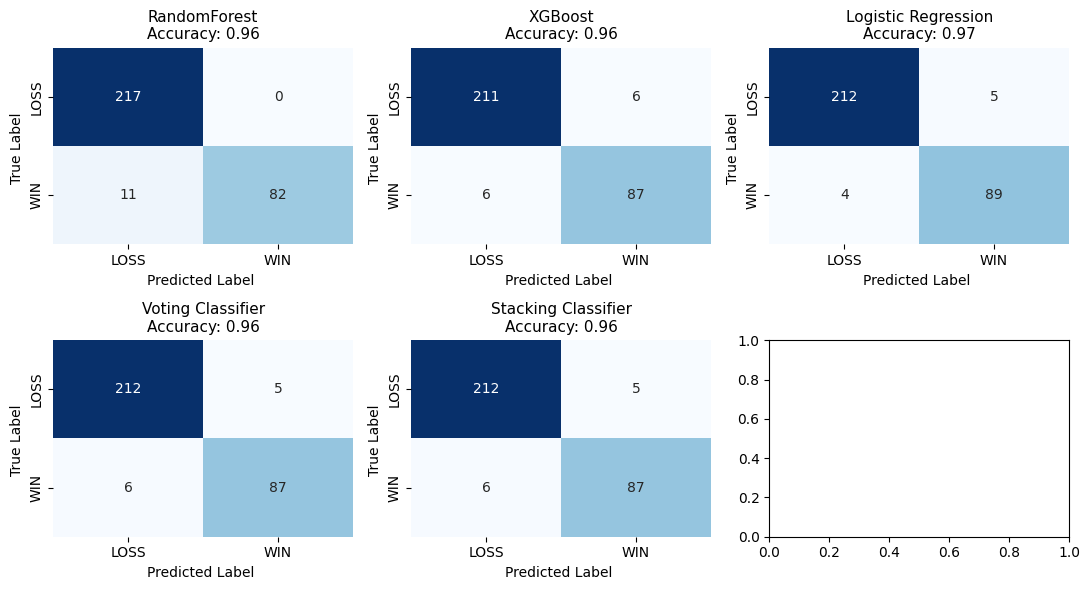

In [174]:
model_names = ['RandomForest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']

regular_binary_predictions = [y_pred_RF, y_pred_XVG, y_pred_LR, y_pred_VC, y_pred_S]
# Plot the confusion matrices horizontally
plot_confusion_matrices_horizontal(y_test, regular_binary_predictions, model_names)

In [ ]:
# Display the final overall statistics DataFrame
# features_filtered = features_filtered[training_feature_cols]
# overall_stats_df = overall_stats(df, features_filtered, training_feature_cols)
overall_stats_df = overall_stats(X_test_P, X_test, training_feature_cols)
print("\nOverall Statistics for Trades Predicted as 'Win' by Each Model:")
overall_stats_df



Overall Statistics for Trades Predicted as 'Win' by Each Model:


,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,RandomForest,82,82,0,14686.68,0.0,972.895801,100.00,3.65,299.01,167.24,0.00,143.25,1.75,13713.78,15.10
1,XGBoost,93,87,6,15375.23,298.0,1101.357723,93.55,3.62,299.01,164.85,-61.03,157.50,1.69,13975.87,10.99
2,Logistic Regression,94,89,5,15710.73,246.0,1126.790642,94.68,3.62,299.01,164.61,-62.43,163.25,1.74,14337.94,11.44
3,Voting Classifier,92,87,5,15375.23,248.0,1090.201193,94.57,3.62,299.01,164.85,-61.01,156.25,1.70,14037.03,11.49
4,Stacking Classifier,92,87,5,15400.23,246.0,1095.211606,94.57,3.63,299.01,165.14,-61.71,160.25,1.74,14059.02,11.48


In [ ]:
time_input = "20:00"  #@param {type:"string"}
date_input = "6/25/2025"  #@param {type:"string"}
criteria_input = "LG RGC UP"  #@param {type:"string"}
CL = 4 #@param {type:"integer"}
CW = 0 #@param {type:"integer"}


input_features = get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols)
# Predict the result
input_features['CL'] = [CL]
input_features['CW'] = [CW]
# input_features = input_features[training_feature_cols]
# print(input_features.head())
if not input_features.empty:
    # Get predictions and probabilities for each model
    rf_predicted_class, rf_predicted_probability = predict_trade_result(RF_model, input_features, training_feature_cols)
    xgb_predicted_class, xgb_predicted_probability = predict_trade_result(XVG_model, input_features, training_feature_cols)
    lr_predicted_class, lr_predicted_probability = predict_trade_result(LR_model, input_features, training_feature_cols)
    VC_model_predicted_class, VC_model_predicted_probability = predict_trade_result(VC_model, input_features, training_feature_cols)
    S_model_predicted_class, S_model_predicted_probability = predict_trade_result(S_model, input_features, training_feature_cols)

    print(f"\n--- Predictions for Date: {date_input}, Time: {time_input}, Criteria: {criteria_input} ---")

    print("\nRandomForest Model:")
    print(f"  Test Set Accuracy: {RF_accuracy:.4f}")
    print(f"  Predicted Result: {'Win' if rf_predicted_class == 1 else 'Loss'}")
    print(f"  Predicted Probability of {'Win' if rf_predicted_class == 1 else 'Loss'}: {np.max(rf_predicted_probability):.4f}")

    print("\nXGBoost Model:")
    print(f"  Test Set Accuracy: {XVG_accuracy:.4f}")
    print(f"  Predicted Result: {'Win' if xgb_predicted_class == 1 else 'Loss'}")
    print(f"  Predicted Probability of {'Win' if rf_predicted_class == 1 else 'Loss'}: {np.max(xgb_predicted_probability):.4f}")

    print("\nLogistic Regression Model:")
    print(f"  Test Set Accuracy: {LR_accuracy:.4f}")
    print(f"  Predicted Result: {'Win' if lr_predicted_class == 1 else 'Loss'}")
    print(f"  Predicted Probability of {'Win' if rf_predicted_class == 1 else 'Loss'}: {np.max(lr_predicted_probability):.4f}")

    print("\nVoting Classifier Model:")
    print(f"  Test Set Accuracy: {VC_accuracy:.4f}")
    print(f"  Predicted Result: {'Win' if VC_model_predicted_class == 1 else 'Loss'}")
    print(f"  Predicted Probability of {'Win' if VC_model_predicted_class == 1 else 'Loss'}: {np.max(VC_model_predicted_probability):.4f}")

    print("\nStacking Classifier Model:")
    print(f"  Test Set Accuracy: {S_accuracy:.4f}")
    print(f"  Predicted Result: {'Win' if S_model_predicted_class == 1 else 'Loss'}")
    print(f"  Predicted Probability of {'Win' if S_model_predicted_class == 1 else 'Loss'}: {np.max(S_model_predicted_probability):.4f}")

else:
    print("Prediction could not be made due to invalid inputs or data.")


--- Predictions for Date: 6/25/2025, Time: 20:00, Criteria: LG RGC UP ---

RandomForest Model:
  Test Set Accuracy: 0.9645
  Predicted Result: Loss
  Predicted Probability of Loss: 0.9500

XGBoost Model:
  Test Set Accuracy: 0.9613
  Predicted Result: Loss
  Predicted Probability of Loss: 0.9999

Logistic Regression Model:
  Test Set Accuracy: 0.9710
  Predicted Result: Loss
  Predicted Probability of Loss: 0.9949

Voting Classifier Model:
  Test Set Accuracy: 0.9645
  Predicted Result: Loss
  Predicted Probability of Loss: 0.9816

Stacking Classifier Model:
  Test Set Accuracy: 0.9645
  Predicted Result: Loss
  Predicted Probability of Loss: 0.9973


##Multiclass - Average R

###Label Encode

In [ ]:
def encode_train_test(y_train_m, y_test_m):
    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train_m)
    y_test_enc = label_encoder.transform(y_test_m)

    # Save the mapping for later decoding
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    reverse_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    return label_encoder, y_train_enc, y_test_enc, class_mapping, reverse_mapping
label_encoder, y_train_enc, y_test_enc, class_mapping, reverse_mapping = encode_train_test(y_train_m, y_test_m)

###Random Forest

In [ ]:
def RF_M(X_train, y_train_enc, X_test, y_test_enc, n_estimators= 100):
    # Initialize and train the model
    # RandomForestClassifier is a good choice for binary classification and handles various feature types well.
    # It's relatively robust to outliers and doesn't require extensive feature scaling.
    # The number of estimators (n_estimators) can be tuned. More trees generally improve performance but increase computation time.
    # random_state for reproducibility
    RF_model_m = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    start_time = time.time()
    RF_model_m.fit(X_train, y_train_enc)
    end_time = time.time()
    # print(f"Training time: {end_time - start_time:.2f} seconds")
    importances = RF_model_m.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    # features_df.plot.bar(x='Feature', y='Importance', figsize=(12, 4), title='Feature Importances')
    # plt.tight_layout()
    # plt.show()

    # Make predictions on the test set
    start_time = time.time()
    y_pred_RF_m= RF_model_m.predict(X_test)
    end_time = time.time()
    # print(f"Prediction time: {end_time - start_time:.2f} seconds")

    # Evaluate the model
    RF_accuracy_m = accuracy_score(y_test_enc, y_pred_RF_m)
    RF_class_report_m = classification_report(y_test_enc, y_pred_RF_m)
    return RF_model_m, y_pred_RF_m, RF_accuracy_m, RF_class_report_m

RF_model_m, y_pred_RF_m, RF_accuracy_m, RF_class_report_m = RF_M(X_train, y_train_enc, X_test, y_test_enc, n_estimators=100)
show_model_result("RandomForest Multi", RF_accuracy_m, RF_class_report_m)


Model: RandomForest Multi
Accuracy: 0.8613

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       217
           1       0.00      0.00      0.00         4
           2       0.66      0.79      0.72        63
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

    accuracy                           0.86       310
   macro avg       0.23      0.26      0.24       310
weighted avg       0.79      0.86      0.82       310



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

###XVG Boost

In [ ]:
def XVG_M(X_train, y_train_enc, X_test, y_test_enc,num_class=5, objective='multi:softmax', eval_metric = 'mlogloss', ul_enc = False):
    # Initialize and train the model
    XVG_model_m = XGBClassifier(
        objective=objective,   # or 'multi:softprob' for probabilities
        num_class=num_class,
        eval_metric=eval_metric,      # Recommended for multi-class
        use_label_encoder=ul_enc,     # Suppress warnings
        random_state=42
    )

    XVG_model_m.fit(X_train, y_train_enc)
    y_pred_XVG_m = XVG_model_m.predict(X_test)

    print("Test class counts:\n", pd.Series(y_test_enc).value_counts())
    print("Predicted class counts:\n", pd.Series(y_pred_XVG_m).value_counts())

    XVG_accuracy_m = accuracy_score(y_test_enc, y_pred_XVG_m)
    XVG_class_report_m = classification_report(y_test_enc, y_pred_XVG_m)
    return XVG_model_m, y_pred_XVG_m, XVG_accuracy_m, XVG_class_report_m

XVG_model_m, y_pred_XVG_m, XVG_accuracy_m, XVG_class_report_m = XVG_M(X_train, y_train_enc, X_test, y_test_enc, num_class=prediction_target['Result_R'].nunique(), objective='multi:softmax', eval_metric = 'mlogloss', ul_enc = False)
show_model_result("XGBoost Multi", XVG_accuracy_m, XVG_class_report_m)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:50:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test class counts:
 0    217
2     63
3     20
4      5
1      4
5      1
Name: count, dtype: int64
Predicted class counts:
 0    224
2     69
4      6
3      5
6      3
1      3
Name: count, dtype: int64

Model: XGBoost Multi
Accuracy: 0.8774

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       217
           1       0.33      0.25      0.29         4
           2       0.77      0.84      0.80        63
           3       0.60      0.15      0.24        20
           4       0.17      0.20      0.18         5
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

    accuracy                           0.88       310
   macro avg       0.40      0.35      0.35       310
weighted avg       0.87      0.88      0.86       310



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

###Logistic Regression

In [ ]:
def LR_M(X_train, y_train_enc, X_test, y_test_enc, solver='lbfgs', max_iter=10000):

    # Pipeline: Scaling + Logistic Regression
    # lr_model_m = LogisticRegression(solver='lbfgs', max_iter=10000, class_weight='balanced', )
    lr_model_m = LogisticRegression(solver=solver, max_iter=max_iter,random_state=42 )
    LR_model_m = make_pipeline(StandardScaler(), lr_model_m)
    # model = RandomForestClassifier()
    # model = XGBClassifier(num_class=5, objective='multi:softmax')

    LR_model_m.fit(X_train, y_train_enc)
    y_pred_LR_m = LR_model_m.predict(X_test)

    LR_accuracy_m = accuracy_score(y_test_enc, y_pred_LR_m)
    LR_class_report_m = classification_report(y_test_enc, y_pred_LR_m)

    return LR_model_m, y_pred_LR_m, LR_accuracy_m, LR_class_report_m

LR_model_m, y_pred_LR_m, LR_accuracy_m, LR_class_report_m = LR_M(X_train, y_train_enc, X_test, y_test_enc, solver='lbfgs', max_iter=10000)
show_model_result("Logistic Regression Multi", LR_accuracy_m, LR_class_report_m)


Model: Logistic Regression Multi
Accuracy: 0.8581

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       217
           1       0.14      0.25      0.18         4
           2       0.69      0.81      0.74        63
           3       1.00      0.05      0.10        20
           4       0.20      0.20      0.20         5
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

    accuracy                           0.86       310
   macro avg       0.43      0.33      0.31       310
weighted avg       0.89      0.86      0.85       310



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Voting Classifier

In [ ]:
def VC_M(X_train, y_train_enc, X_test, y_test_enc, num_class=5, voting='soft', solver='lbfgs', max_iter=10000, objective='multi:softmax',  eval_metric='mlogloss', ul_enc=False):
    lr = make_pipeline(StandardScaler(), LogisticRegression(solver=solver, max_iter=max_iter, random_state=42 )) #class_weight='balanced',

    rf = RandomForestClassifier(random_state=42)

    xgb = XGBClassifier(
        objective=objective,
        num_class=num_class,
        eval_metric=eval_metric,
        use_label_encoder=ul_enc,
        random_state=42
    )

    # Check all estimators before using
    # for name, model in [('lr', lr), ('rf', rf), ('xgb', xgb)]:
    #     model.fit(X_train, y_train_enc)
    #     proba = model.predict_proba(X_test)
    #     print(f"{name} proba shape: {proba.shape}")

    VC_model_m = VotingClassifier(
        estimators=[
            ('lr', lr),
            ('rf', rf),
            ('xgb', xgb)
        ],
        voting=voting # Use 'soft' for probability averaging (recommended for multi-class)
    )

    VC_model_m.fit(X_train, y_train_enc)
    y_pred_VC_m = VC_model_m.predict(X_test)

    VC_accuracy_m = accuracy_score(y_test_enc, y_pred_VC_m)
    VC_class_report_m = classification_report(y_test_enc, y_pred_VC_m)

    return VC_model_m, y_pred_VC_m, VC_accuracy_m, VC_class_report_m
print(X_train.shape, y_train_enc.shape, X_test.shape, y_test_enc.shape)
VC_model_m, y_pred_VC_m, VC_accuracy_m, VC_class_report_m = VC_M(X_train, y_train_enc, X_test, y_test_enc, num_class=prediction_target['Result_R'].nunique(), voting='soft', solver='lbfgs', max_iter=1000, objective='multi:softmax', eval_metric='mlogloss', ul_enc=False)
show_model_result("Voting Classifier Multi", VC_accuracy_m, VC_class_report_m)

(2783, 83) (2783,) (310, 83) (310,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Voting Classifier Multi
Accuracy: 0.8806

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       217
           1       0.50      0.25      0.33         4
           2       0.72      0.84      0.77        63
           3       1.00      0.15      0.26        20
           4       0.50      0.20      0.29         5
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

    accuracy                           0.88       310
   macro avg       0.52      0.35      0.37       310
weighted avg       0.89      0.88      0.86       310



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

###Stacking Classifier

In [ ]:
def S_M(X_train, y_train_enc, X_test, y_test_enc, num_class=5, solver='lbfgs', max_iter=10000, objective='multi:softmax', eval_metric='mlogloss',cv =5, n_jobs=-1, ul_enc=False):

    lr_p2_m = make_pipeline(StandardScaler(), LogisticRegression(solver=solver, max_iter=max_iter, random_state=42 )) #class_weight='balanced',
    base_models = [
        ('lr', lr_p2_m),
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(objective=objective, num_class=num_class, eval_metric=eval_metric, use_label_encoder=ul_enc,))
    ]
    final_estimator = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=max_iter, random_state=42, ) #class_weight='balanced',
    )
    S_model_m = StackingClassifier(
        estimators=base_models,
        final_estimator=final_estimator,
        passthrough=True,
        cv=cv,
        n_jobs=n_jobs
    )

    S_model_m .fit(X_train, y_train_enc)
    y_pred_S_m = S_model_m .predict(X_test)

    S_accuracy_m = accuracy_score(y_test_enc, y_pred_S_m)
    S_class_report_m = classification_report(y_test_enc, y_pred_S_m)
    return S_model_m, y_pred_S_m, S_accuracy_m, S_class_report_m

S_model_m, y_pred_S_m, S_accuracy_m, S_class_report_m = S_M(X_train, y_train_enc, X_test, y_test_enc,num_class=prediction_target['Result_R'].nunique(), solver='lbfgs', max_iter=10000, objective='multi:softmax', eval_metric='mlogloss',cv =5, n_jobs=-1, ul_enc=False)
show_model_result("Stacking Classifier Multi", S_accuracy_m, S_class_report_m)


Model: Stacking Classifier Multi
Accuracy: 0.8645

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       217
           1       0.00      0.00      0.00         4
           2       0.69      0.87      0.77        63
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

    accuracy                           0.86       310
   macro avg       0.24      0.26      0.25       310
weighted avg       0.82      0.86      0.84       310



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# List of predictions from the trained models
model_names = ['RandomForest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']

regular_binary_predictions = [y_pred_RF, y_pred_XVG, y_pred_LR, y_pred_VC, y_pred_S]
regular_multi_predictions= [y_pred_RF_m, y_pred_XVG_m, y_pred_LR_m, y_pred_VC_m, y_pred_S_m]

regular_binary_models = [RF_model, XVG_model, LR_model, VC_model, S_model]
regular_multi_models = [RF_model_m, XVG_model_m, LR_model_m, VC_model_m, S_model_m]

regular_binary_accuracy= [RF_accuracy, XVG_accuracy, LR_accuracy, VC_accuracy, S_accuracy]
regular_multi_accuracy = [RF_accuracy_m, XVG_accuracy_m, LR_accuracy_m, VC_accuracy_m, S_accuracy_m]

regular_accuracies = {
    'Model': model_names,
    'Binary Accuracy': regular_binary_accuracy,
    'Multi-Class (R Bucket) Accuracy': regular_multi_accuracy
}

regular_model_accuracies = pd.DataFrame(regular_accuracies)

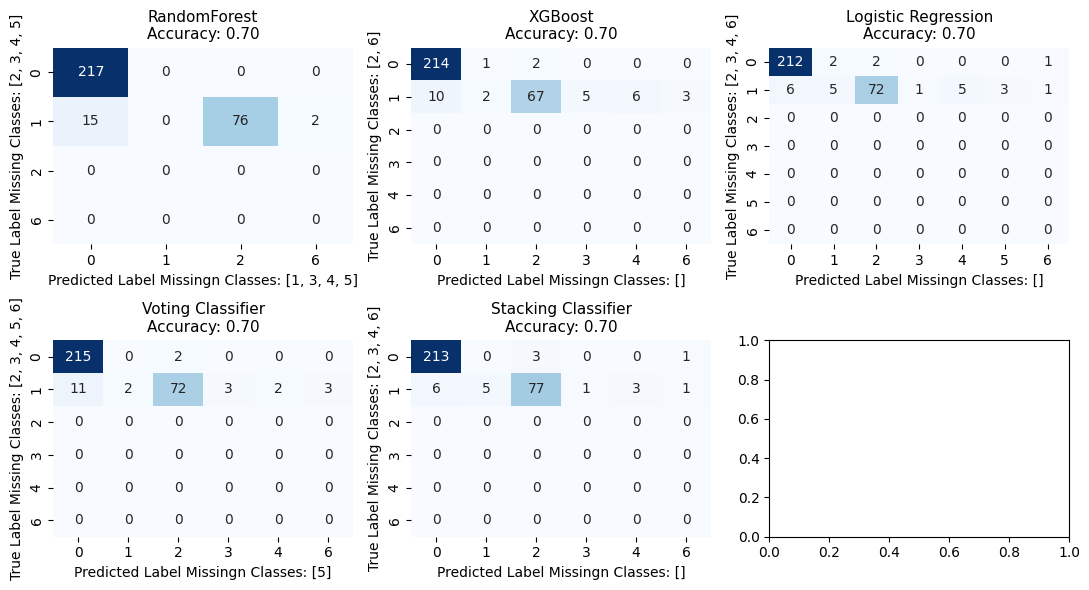

In [ ]:
plot_confusion_matrices_horizontal(y_test, regular_multi_predictions, model_names,ticks = sorted(np.unique(y_test_enc)))

###Result Analysis & Visualization

In [ ]:
time_input = "17:00"  #@param {type:"string"}
date_input = "6/26/2025"  #@param {type:"string"}
criteria_input = "ELC"  #@param {type:"string"}
CL = 6 #@param {type:"integer"}
CW = 0 #@param {type:"integer"}

# Define model base names
model_names = ['RandomForest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

show_predictions(time_input, date_input, criteria_input,  CL, CW, training_feature_cols, model_names, model_keys, precomputed_stats=precomputed_stats,label_encoder=label_encoder, b_models=regular_binary_models, m_models=regular_multi_models, b_acc=regular_accuracies['Binary Accuracy'], m_acc=regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)

# Plot the confusion matrices horizontally
# plot_confusion_matrices_horizontal(y_test, all_predictions, model_names)


--- 📊 Combined Model Predictions for 6/26/2025 17:00 (ELC) - ---

Overall decision: ---- Binary: ** Loss **  Multi: ** Loss** ----  
Binary Models: Win Predicted **0 time **    Multi Models: Win Predicted **0**
╒═════════════════════╤════════════════════════╤═════════════════════════════╕
│ Model               │ 📘 Binary (Win/Loss)   │ 📗 Multi-Class (R Bucket)   │
╞═════════════════════╪════════════════════════╪═════════════════════════════╡
│ RandomForest        │ Loss (0.81), Acc: 0.96 │ Class 1 (0.75), Acc: 0.86   │
├─────────────────────┼────────────────────────┼─────────────────────────────┤
│ XGBoost             │ Loss (1.00), Acc: 0.96 │ Class 1 (1.00), Acc: 0.88   │
├─────────────────────┼────────────────────────┼─────────────────────────────┤
│ Logistic Regression │ Loss (0.93), Acc: 0.97 │ Class 1 (0.95), Acc: 0.86   │
├─────────────────────┼────────────────────────┼─────────────────────────────┤
│ Voting Classifier   │ Loss (0.91), Acc: 0.96 │ Class 1 (0.90), Acc: 0.88   │


([np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)],
 [np.int64(0), np.int32(0), np.int64(0), np.int64(0), np.int64(0)])

In [ ]:
# Display the final overall statistics DataFrame
# overall_stats_df = overall_stats(df, features_filtered,training_feature_cols)
overall_stats_df = overall_stats(X_test_P, X_test,training_feature_cols)
print("\nOverall Statistics for Trades Predicted as 'Win' by Each Model:")
overall_stats_df



Overall Statistics for Trades Predicted as 'Win' by Each Model:


,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,RandomForest,82,82,0,14686.68,0.0,972.895801,100.00,3.65,299.01,167.24,0.00,143.25,1.75,13713.78,15.10
1,XGBoost,93,87,6,15375.23,298.0,1101.357723,93.55,3.62,299.01,164.85,-61.03,157.50,1.69,13975.87,10.99
2,Logistic Regression,94,89,5,15710.73,246.0,1126.790642,94.68,3.62,299.01,164.61,-62.43,163.25,1.74,14337.94,11.44
3,Voting Classifier,92,87,5,15375.23,248.0,1090.201193,94.57,3.62,299.01,164.85,-61.01,156.25,1.70,14037.03,11.49
4,Stacking Classifier,92,87,5,15400.23,246.0,1095.211606,94.57,3.63,299.01,165.14,-61.71,160.25,1.74,14059.02,11.48


In [ ]:
!rm -rf /content/*

In [ ]:
def filter_trades_by_prediction(df, X_test, model):
  # Predict on the feature set
  pred_result = model.predict(X_test)

  # Get the indices where the prediction is 'Win' (class 1)
  win_indices = X_test.iloc[pred_result == 1].index

  # Filter the original DataFrame using these indices
  df_filtered_win = df.loc[win_indices]

  return df_filtered_win

def get_prediction_trade_files(df, X_test, models, file_dir):
    predicted_win_dfs = []
    for model_name, model in models.items():
        # Filter the X_test_P DataFrame (which contains the original columns for the test set)
        # based on the prediction from the corresponding binary model using the X_test features.
        df_trades_predicted_win = filter_trades_by_prediction(df, X_test, model)
        # print(df_trades_predicted_win.shape)
        predicted_win_dfs.append(df_trades_predicted_win)

        # Define the output filename
        output_filename = f'{file_dir}{model_name}_Predicted_Wins.xlsx'
        print(f"Saved trades predicted as 'Win' by {model_name} to '{output_filename}'")

        # Save the filtered DataFrame to an Excel file
        df_trades_predicted_win.to_excel(output_filename, index=False)
    combined_predicted_wins = pd.concat(predicted_win_dfs, ignore_index=True)
    combined_predicted_wins_unique = combined_predicted_wins.drop_duplicates(subset=['S/l']).sort_values(by='S/l')
    return combined_other_models_predicted_wins_unique, predicted_win_dfs

In [ ]:
binary_models = {
    'RandomForest': RF_model,
    'XGBoost': XVG_model,
    'Logistic Regression': LR_model,
    'Voting Classifier': VC_model,
    'Stacking Classifier': S_model
}

file_dir = 'trade_files/'
os.makedirs(file_dir, exist_ok=True)

combined_predicted_wins_unique, predicted_win_dfs = get_prediction_trade_files(df, X_test, binary_models, file_dir)
combined_predicted_wins_unique.to_excel(f'{file_dir}regular_combined_prediction.xlsx', index=False)
print("\nCombined and unique predicted wins saved to 'All_Models_Predicted_Wins_Unique.xlsx'")

RFS_LC_predicted_wins_unique = pd.concat([predicted_win_dfs[0], predicted_win_dfs[2]], ignore_index=True).drop_duplicates(subset=['S/l']).sort_values(by='S/l')
RFS_LC_predicted_wins_unique.to_excel(f'{file_dir}RFS_LC.xlsx', index=False)
combined_predicted_wins_unique.shape

Saved trades predicted as 'Win' by RandomForest to 'trade_files/RandomForest_Predicted_Wins.xlsx'
Saved trades predicted as 'Win' by XGBoost to 'trade_files/XGBoost_Predicted_Wins.xlsx'
Saved trades predicted as 'Win' by Logistic Regression to 'trade_files/Logistic Regression_Predicted_Wins.xlsx'
Saved trades predicted as 'Win' by Voting Classifier to 'trade_files/Voting Classifier_Predicted_Wins.xlsx'
Saved trades predicted as 'Win' by Stacking Classifier to 'trade_files/Stacking Classifier_Predicted_Wins.xlsx'

Combined and unique predicted wins saved to 'All_Models_Predicted_Wins_Unique.xlsx'


(97, 38)

In [ ]:
xgboost_predicted_wins_df = predicted_win_dfs[1] # XGBoost is at index 1

# Combine predicted wins from all models EXCEPT XGBoost
other_models_predicted_wins_dfs = [df for i, df in enumerate(predicted_win_dfs) if i != 1]
combined_other_models_predicted_wins = pd.concat(other_models_predicted_wins_dfs, ignore_index=True)
combined_other_models_predicted_wins_unique = combined_other_models_predicted_wins.drop_duplicates(subset=['S/l'])

# Calculate losses for trades in each group
# A trade is a 'Loss' if 'Profit/Loss' is negative
xgboost_losses = xgboost_predicted_wins_df[xgboost_predicted_wins_df['Profit/Loss'] < 0]
other_combined_losses = combined_other_models_predicted_wins_unique[combined_other_models_predicted_wins_unique['Profit/Loss'] < 0]

# Compare the losses
print("\n--- Comparison of Losses ---")
print(f"Number of Losses in Trades Predicted as 'Win' by XGBoost: {len(xgboost_losses)}")
print(f"Total Loss Amount for XGBoost Predicted Wins: {xgboost_losses['Profit/Loss'].sum():.2f}")
print(f"Average Loss Amount for XGBoost Predicted Wins: {xgboost_losses['Profit/Loss'].mean():.2f}")

print(f"\nNumber of Losses in Trades Predicted as 'Win' by Other Combined Models: {len(other_combined_losses)}")
print(f"Total Loss Amount for Other Combined Models Predicted Wins: {other_combined_losses['Profit/Loss'].sum():.2f}")
print(f"Average Loss Amount for Other Combined Models Predicted Wins: {other_combined_losses['Profit/Loss'].mean():.2f}")



--- Comparison of Losses ---
Number of Losses in Trades Predicted as 'Win' by XGBoost: 6
Total Loss Amount for XGBoost Predicted Wins: -366.19
Average Loss Amount for XGBoost Predicted Wins: -61.03

Number of Losses in Trades Predicted as 'Win' by Other Combined Models: 6
Total Loss Amount for Other Combined Models Predicted Wins: -367.99
Average Loss Amount for Other Combined Models Predicted Wins: -61.33


In [ ]:
# prompt: show xgb model predicted win that actully win s/l difference betwwen other model combine predicted win and actually win uniuqe

# Filter trades predicted as 'Win' by XGBoost and see which ones were actually 'Win' or 'Loss'
xgboost_predicted_wins_actual_results = xgboost_predicted_wins_df[['S/l', 'Result', 'Profit/Loss']]


# Filter trades predicted as 'Win' by combined Other Models and see which ones were actually 'Win' or 'Loss'
other_combined_predicted_wins_actual_results = combined_other_models_predicted_wins_unique[['S/l', 'Result', 'Profit/Loss']]


# Find the unique S/l values where XGBoost predicted Win and the actual result was Win
xgboost_actual_wins_sl = xgboost_predicted_wins_df[xgboost_predicted_wins_df['Result'] == 'W']['S/l'].unique()
print(f"\nUnique S/l where XGBoost Predicted Win and Actually Won: {len(xgboost_actual_wins_sl)}")

# Find the unique S/l values where combined Other Models predicted Win and the actual result was Win
other_combined_actual_wins_sl = combined_other_models_predicted_wins_unique[combined_other_models_predicted_wins_unique['Result'] == 'W']['S/l'].unique()
print(f"Unique S/l where Other Combined Models Predicted Win (Unique S/l) and Actually Won: {len(other_combined_actual_wins_sl)}")

# Find the S/l values that are unique to XGBoost (predicted Win and actually Won)
unique_to_xgboost_actual_wins_sl = np.setdiff1d(xgboost_actual_wins_sl, other_combined_actual_wins_sl)
print(f"\nUnique S/l where ONLY XGBoost Predicted Win and Actually Won: {len(unique_to_xgboost_actual_wins_sl)}")
print(f"List of S/l unique to XGBoost actual wins: {unique_to_xgboost_actual_wins_sl.tolist()}")

# Find the S/l values that are unique to Other Combined Models (predicted Win and actually Won)
unique_to_other_combined_actual_wins_sl = np.setdiff1d(other_combined_actual_wins_sl, xgboost_actual_wins_sl)
print(f"\nUnique S/l where ONLY Other Combined Models Predicted Win (Unique S/l) and Actually Won: {len(unique_to_other_combined_actual_wins_sl)}")
print(f"List of S/l unique to Other Combined Models actual wins: {unique_to_other_combined_actual_wins_sl.tolist()}")

# Find the S/l values where both predicted Win and actually Won
common_actual_wins_sl = np.intersect1d(xgboost_actual_wins_sl, other_combined_actual_wins_sl)
print(f"\nUnique S/l where Both XGBoost and Other Combined Models Predicted Win and Actually Won: {len(common_actual_wins_sl)}")
print(f"List of S/l common actual wins: {common_actual_wins_sl.tolist()}")


# Filter trades predicted as 'Win' by XGBoost and the actual result was 'Loss'
xgboost_predicted_win_actual_loss_sl = xgboost_predicted_wins_df[xgboost_predicted_wins_df['Result'] == 'L']['S/l'].unique()
print(f"\nUnique S/l where XGBoost Predicted Win and Actually Lost: {len(xgboost_predicted_win_actual_loss_sl)}")

# Filter trades predicted as 'Win' by combined Other Models (unique S/l) and the actual result was 'Loss'
other_combined_predicted_win_actual_loss_sl = combined_other_models_predicted_wins_unique[combined_other_models_predicted_wins_unique['Result'] == 'L']['S/l'].unique()
print(f"Unique S/l where Other Combined Models Predicted Win (Unique S/l) and Actually Lost: {len(other_combined_predicted_win_actual_loss_sl)}")

# Find the unique S/l values in XGBoost predicted win and actually loss
unique_to_xgboost_predicted_win_actual_loss_sl = np.setdiff1d(xgboost_predicted_win_actual_loss_sl, other_combined_predicted_win_actual_loss_sl)
print(f"\nUnique S/l where ONLY XGBoost Predicted Win and Actually Lost: {len(unique_to_xgboost_predicted_win_actual_loss_sl)}")
print(f"List of S/l unique to XGBoost predicted win and actual loss: {unique_to_xgboost_predicted_win_actual_loss_sl.tolist()}")

# Find the S/l values that are unique to Other Combined Models (predicted Win and actually Loss)
unique_to_other_combined_predicted_win_actual_loss_sl = np.setdiff1d(other_combined_predicted_win_actual_loss_sl, xgboost_predicted_win_actual_loss_sl)
print(f"\nUnique S/l where ONLY Other Combined Models Predicted Win (Unique S/l) and Actually Lost: {len(unique_to_other_combined_predicted_win_actual_loss_sl)}")
print(f"List of S/l unique to Other Combined Models predicted win and actual loss: {unique_to_other_combined_predicted_win_actual_loss_sl.tolist()}")

# Find the S/l values where both predicted Win and actually Lost
common_predicted_win_actual_loss_sl = np.intersect1d(xgboost_predicted_win_actual_loss_sl, other_combined_predicted_win_actual_loss_sl)
print(f"\nUnique S/l where Both XGBoost and Other Combined Models Predicted Win and Actually Lost: {len(common_predicted_win_actual_loss_sl)}")
print(f"List of S/l common predicted win and actual loss: {common_predicted_win_actual_loss_sl.tolist()}")



Unique S/l where XGBoost Predicted Win and Actually Won: 87
Unique S/l where Other Combined Models Predicted Win (Unique S/l) and Actually Won: 91

Unique S/l where ONLY XGBoost Predicted Win and Actually Won: 0
List of S/l unique to XGBoost actual wins: []

Unique S/l where ONLY Other Combined Models Predicted Win (Unique S/l) and Actually Won: 4
List of S/l unique to Other Combined Models actual wins: [2801, 2825, 3043, 3079]

Unique S/l where Both XGBoost and Other Combined Models Predicted Win and Actually Won: 87
List of S/l common actual wins: [2785, 2791, 2793, 2794, 2802, 2808, 2810, 2816, 2818, 2829, 2830, 2831, 2834, 2837, 2839, 2843, 2845, 2846, 2853, 2855, 2859, 2866, 2867, 2868, 2872, 2874, 2880, 2881, 2883, 2892, 2893, 2895, 2899, 2901, 2905, 2907, 2913, 2915, 2930, 2938, 2939, 2940, 2943, 2949, 2953, 2954, 2958, 2961, 2963, 2965, 2982, 2984, 2986, 2987, 2989, 2992, 2993, 2996, 2998, 3001, 3002, 3005, 3007, 3010, 3011, 3017, 3018, 3022, 3030, 3034, 3037, 3039, 3041, 3042

In [ ]:
# prompt: save other_combined_losses

# combined_other_models_predicted_wins_unique.to_excel('Other_Combined.xlsx', index=False)


##ML-Max R

In [ ]:
df_max_r = pd.read_excel('SSL_T_MR.xlsx')

In [ ]:
# prompt: count  of R value in df_max_r  that jave Result == 'W' greater than 5 and less then 9

# Filter the DataFrame where 'Result' is 'W'
df_wins = df_max_r[df_max_r['Result'] == 'W']

# Count occurrences where 'R' is greater than 5 and less than 9
r_count = df_wins[(df_wins['R'] > 8) & (df_wins['R'] < 100)].shape[0]

print(f"Count of 'R' values in df_max_r that have 'Result' == 'W' and are between 5 and 9: {r_count}")


Count of 'R' values in df_max_r that have 'Result' == 'W' and are between 5 and 9: 326


In [ ]:
df_max_r = prepare_data(df_max_r)
df_max_r = calculate_prior_streaks(df_max_r)

In [ ]:
precomputed_stats_max_r = get_precomputed_stats(df_max_r)
# Save precomputed_stats
joblib.dump(precomputed_stats_max_r, 'precomputed_stats_max_r.pkl')
precomputed_stats_max_r = joblib.load('precomputed_stats_max_r.pkl')

In [ ]:
train_data_max_r = get_train_data(df_max_r, precomputed_stats_max_r)
train_data_max_r = processing_train_data(df_max_r, train_data_max_r, R_threshold=7)
train_data_max_r = save_read_train_data(train_data_max_r, name = 'train_data_max_r')
# train_data_max_r = convert_train_data_type(train_data_max_r)

In [ ]:
features_max_r, features_filtered_max_r, prediction_target_max_r = extract_ptarget_feature(train_data_max_r)
X_train_max_r, X_test_max_r, y_train_max_r, y_test_max_r, y_train_m_max_r, y_test_m_max_r, X_train_P_max_r, X_test_P_max_r= split_data(features_max_r, prediction_target_max_r)
show_split_data(X_train_max_r, X_test_max_r, y_train_max_r, y_test_max_r, y_train_m_max_r, y_test_m_max_r)

Shape of X_train: (2783, 83)
Shape of X_test: (310, 83)
Shape of y_train: (2783,)
Shape of y_test: (310,)
Shape of y_train_m: (2783,)
Shape of y_test_m: (310,)


In [ ]:
training_feature_cols_max_r = X_train_max_r.columns
# X_train_max_r.info()

In [ ]:
RF_model_max_r,y_pred_RF_max_r, RF_accuracy_max_r, RF_class_report_max_r = RF(X_train_max_r, X_test_max_r, y_train_max_r, y_test_max_r, n_estimators=100)
show_model_result("Random Forest-Max R", RF_accuracy, RF_class_report)

XVG_model_max_r, y_pred_XVG_max_r, XVG_accuracy_max_r, XVG_class_report_max_r = XVG(X_train_max_r, X_test_max_r, y_train_max_r, y_test_max_r, eval_metric='logloss')
show_model_result("XGBoost-Max R", XVG_accuracy_max_r, XVG_class_report_max_r)

LR_model_max_r,y_pred_LR_max_r, LR_accuracy_max_r, LR_class_report_max_r = LR(X_train_max_r, X_test_max_r, y_train_max_r, y_test_max_r, solver='lbfgs', max_iter=1000)
show_model_result("Logistic Regression-Max R", LR_accuracy_max_r, LR_class_report_max_r)

VC_model_max_r,y_pred_VC_max_r, VC_accuracy_max_r, VC_class_report_max_r = VC(X_train_max_r, X_test_max_r, y_train_max_r, y_test_max_r, max_iter= 1000, eval_metric='logloss', voting='soft')
show_model_result("Voting Classifier-Max R", VC_accuracy_max_r, VC_class_report_max_r)

S_model_max_r,y_pred_S_max_r, S_accuracy_max_r, S_class_report_max_r = S(X_train_max_r, X_test_max_r, y_train_max_r, y_test_max_r, max_iter= 1000, eval_metric='logloss', cv=5, n_jobs=-1, ul_enc=False)
show_model_result("Stacking Classifier-Max R", S_accuracy_max_r, S_class_report_max_r)


Model: Random Forest-Max R
Accuracy: 0.9645

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       217
           1       1.00      0.88      0.94        93

    accuracy                           0.96       310
   macro avg       0.98      0.94      0.96       310
weighted avg       0.97      0.96      0.96       310


Model: XGBoost-Max R
Accuracy: 0.9677

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       217
           1       0.95      0.95      0.95        93

    accuracy                           0.97       310
   macro avg       0.96      0.96      0.96       310
weighted avg       0.97      0.97      0.97       310


Model: Logistic Regression-Max R
Accuracy: 0.9710

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       217
           1       0.97      0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:55:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Voting Classifier-Max R
Accuracy: 0.9677

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       217
           1       0.96      0.94      0.95        93

    accuracy                           0.97       310
   macro avg       0.96      0.96      0.96       310
weighted avg       0.97      0.97      0.97       310


Model: Stacking Classifier-Max R
Accuracy: 0.9645

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       217
           1       0.96      0.92      0.94        93

    accuracy                           0.96       310
   macro avg       0.96      0.95      0.96       310
weighted avg       0.96      0.96      0.96       310



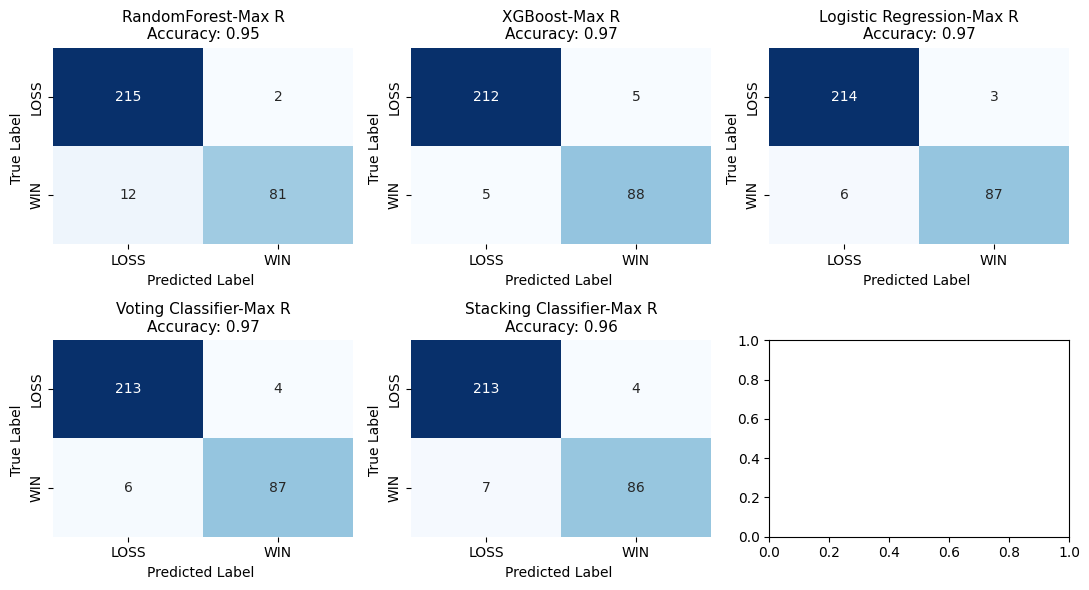

In [ ]:
# List of predictions from the trained models
regular_binary_predictions_max_r = [y_pred_RF_max_r, y_pred_XVG_max_r, y_pred_LR_max_r, y_pred_VC_max_r, y_pred_S_max_r]

# List of model names
model_names_max_r = ['RandomForest-Max R', 'XGBoost-Max R', 'Logistic Regression-Max R', 'Voting Classifier-Max R', 'Stacking Classifier-Max R']

# Plot the confusion matrices horizontally
plot_confusion_matrices_horizontal(y_test_max_r, regular_binary_predictions_max_r , model_names_max_r)

In [ ]:
label_encoder_max_r, y_train_enc_max_r, y_test_enc_max_r, class_mapping_max_r, reverse_mapping_max_r = encode_train_test(y_train_m_max_r, y_test_m_max_r)

In [ ]:
RF_model_m_max_r, y_pred_RF_m_max_r, RF_accuracy_m_max_r, RF_class_report_m_max_r = RF_M(X_train_max_r, y_train_enc_max_r, X_test_max_r, y_test_enc_max_r, n_estimators=100)
show_model_result("RandomForest Multi-Max R", RF_accuracy_m_max_r, RF_class_report_m_max_r)

XVG_model_m_max_r, y_pred_XVG_m_max_r, XVG_accuracy_m_max_r, XVG_class_report_m_max_r = XVG_M(X_train_max_r, y_train_enc_max_r, X_test_max_r, y_test_enc_max_r,num_class=prediction_target['Result_R'].nunique(), objective='multi:softmax', eval_metric = 'mlogloss', ul_enc = False)
show_model_result("XGBoost Multi-Max R", XVG_accuracy_m_max_r, XVG_class_report_m_max_r)

LR_model_m_max_r, y_pred_LR_m_max_r, LR_accuracy_m_max_r, LR_class_report_m_max_r = LR_M(X_train_max_r, y_train_enc_max_r, X_test_max_r, y_test_enc_max_r, solver='lbfgs', max_iter=10000)
show_model_result("Logistic Regression Multi-Max R", LR_accuracy_m_max_r, LR_class_report_m_max_r)

VC_model_m_max_r, y_pred_VC_m_max_r, VC_accuracy_m_max_r, VC_class_report_m_max_r = VC_M(X_train_max_r, y_train_enc_max_r, X_test_max_r, y_test_enc_max_r,num_class=prediction_target['Result_R'].nunique(), voting='soft', solver='lbfgs', max_iter=1000, objective='multi:softmax', eval_metric='mlogloss',ul_enc=False)
show_model_result("Voting Classifier Multi-Max R", VC_accuracy_m_max_r, VC_class_report_m_max_r)

S_model_m_max_r, y_pred_S_m_max_r, S_accuracy_m_max_r, S_class_report_m_max_r = S_M(X_train_max_r, y_train_enc_max_r, X_test_max_r, y_test_enc_max_r,num_class=prediction_target['Result_R'].nunique(), solver='lbfgs', max_iter=10000, objective='multi:softmax', eval_metric='mlogloss',cv =5, n_jobs=-1, ul_enc=False)
show_model_result("Stacking Classifier Multi-Max R", S_accuracy_m_max_r, S_class_report_m_max_r)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c


Model: RandomForest Multi-Max R
Accuracy: 0.8065

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       218
           1       0.00      0.00      0.00         4
           2       0.45      0.54      0.49        26
           3       0.33      0.05      0.08        21
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00         9
           6       0.50      0.89      0.64        19

    accuracy                           0.81       310
   macro avg       0.31      0.35      0.31       310
weighted avg       0.73      0.81      0.75       310

Test class counts:
 0    218
2     26
3     21
6     19
4     13
5      9
1      4
Name: count, dtype: int64
Predicted class counts:
 0    230
6     30
2     26
3     10
1      9
4      4
5      1
Name: count, dtype: int64

Model: XGBoost Multi-Max R
Accuracy: 0.8419

Classification Report:
              precision    recall  f1

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:56:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Voting Classifier Multi-Max R
Accuracy: 0.8290

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       218
           1       0.40      0.50      0.44         4
           2       0.57      0.62      0.59        26
           3       0.50      0.24      0.32        21
           4       1.00      0.08      0.14        13
           5       0.00      0.00      0.00         9
           6       0.52      0.84      0.64        19

    accuracy                           0.83       310
   macro avg       0.56      0.47      0.44       310
weighted avg       0.81      0.83      0.80       310


Model: Stacking Classifier Multi-Max R
Accuracy: 0.8226

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       218
           1       0.25      0.25      0.25         4
           2       0.59      0.62      0.60        26
           3       0.50   

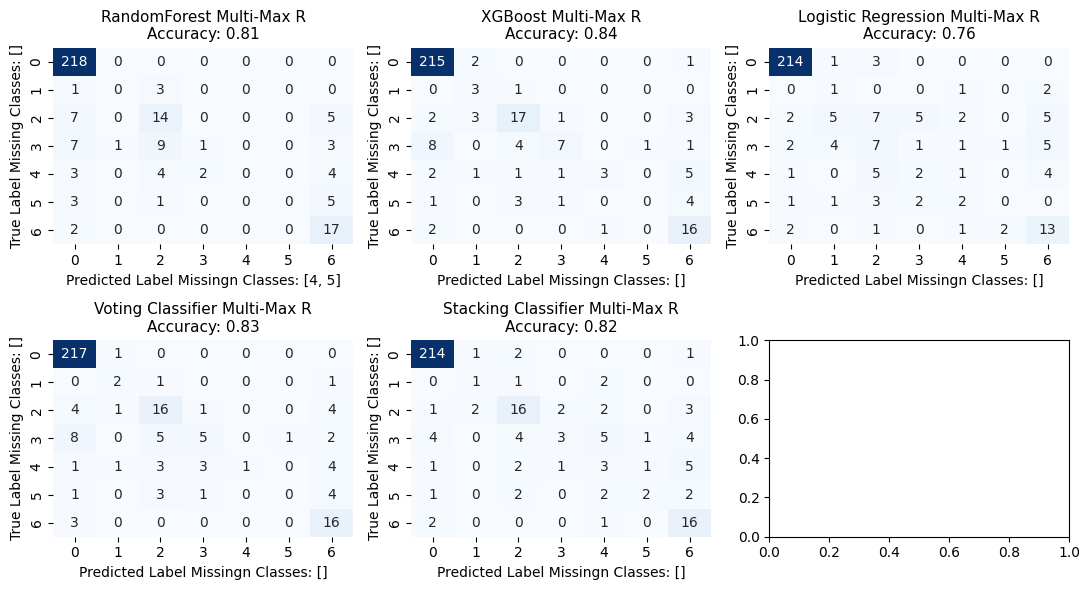

In [ ]:
# List of predictions from the trained models
regular_multi_predictions_max_r = [y_pred_RF_m_max_r, y_pred_XVG_m_max_r, y_pred_LR_m_max_r, y_pred_VC_m_max_r, y_pred_S_m_max_r]
# List of model names
model_names_m_max_r = ['RandomForest Multi-Max R', 'XGBoost Multi-Max R', 'Logistic Regression Multi-Max R', 'Voting Classifier Multi-Max R', 'Stacking Classifier Multi-Max R']

# Plot the confusion matrices horizontally
plot_confusion_matrices_horizontal(y_test_enc_max_r, regular_multi_predictions_max_r, model_names_m_max_r ,ticks = sorted(np.unique(y_test_enc_max_r)))

In [ ]:
model_names_max_r = ['RandomForest Multi-Max R', 'XGBoost Multi-Max R', 'Logistic Regression Multi-Max R', 'Voting Classifier Multi-Max R', 'Stacking Classifier Multi-Max R']
regular_binary_models_max_r = [RF_model_max_r, XVG_model_max_r, LR_model_max_r, VC_model_max_r, S_model_max_r]
regular_multi_models_max_r = [RF_model_m_max_r, XVG_model_m_max_r, LR_model_m_max_r, VC_model_m_max_r, S_model_m_max_r]

regular_binary_accuracy_max_r= [RF_accuracy_max_r, XVG_accuracy_max_r, LR_accuracy_max_r, VC_accuracy_max_r, S_accuracy_max_r]
regular_multi_accuracy_max_r = [RF_accuracy_m_max_r, XVG_accuracy_m_max_r, LR_accuracy_m_max_r, VC_accuracy_m_max_r, S_accuracy_m_max_r]

regular_accuracies_max_r = {
    'Model': model_names_m_max_r,
    'Binary Accuracy': regular_binary_accuracy_max_r,
    'Multi-Class (R Bucket) Accuracy': regular_multi_accuracy_max_r
}

regular_model_accuracies_max_r = pd.DataFrame(regular_accuracies_max_r)


--- 📊 Combined Model Predictions for 6/27/2025 15:00 (ELC) -_max_r ---

Overall decision: ---- Binary: ** Loss **  Multi: ** Win** ---- - Max R: 6 - Average R:6.0
Binary Models: Win Predicted **0 time **    Multi Models: Win Predicted **1**
╒═══════════════════════════╤════════════════════════╤═════════════════════════════╕
│ Model                     │ 📘 Binary (Win/Loss)   │ 📗 Multi-Class (R Bucket)   │
╞═══════════════════════════╪════════════════════════╪═════════════════════════════╡
│ RandomForest Max R        │ Loss (0.60), Acc: 0.95 │ Class 1 (0.60), Acc: 0.81   │
├───────────────────────────┼────────────────────────┼─────────────────────────────┤
│ XGBoost Max R             │ Loss (0.97), Acc: 0.97 │ Class 1 (0.99), Acc: 0.84   │
├───────────────────────────┼────────────────────────┼─────────────────────────────┤
│ Logistic Regression Max R │ Loss (0.97), Acc: 0.97 │ Class 1 (0.84), Acc: 0.76   │
├───────────────────────────┼────────────────────────┼──────────────────────────

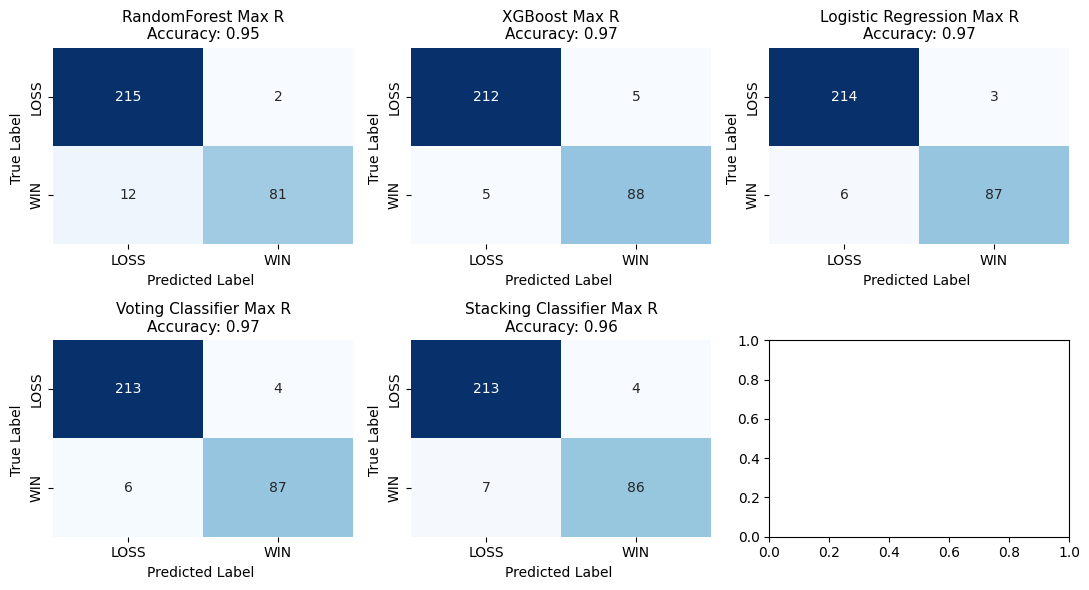

In [ ]:
time_input = "15:00"  #@param {type:"string"}
date_input = "6/27/2025"  #@param {type:"string"}
criteria_input = "ELC"  #@param {type:"string"}
CL = 1 #@param {type:"integer"}
CW = 0 #@param {type:"integer"}

model_names_max_r = ['RandomForest Max R', 'XGBoost Max R', 'Logistic Regression Max R', 'Voting Classifier Max R', 'Stacking Classifier Max R']
model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']
show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols, model_names_max_r, model_keys,precomputed_stats=precomputed_stats,label_encoder=label_encoder, b_models=regular_binary_models_max_r, m_models=regular_multi_models_max_r, b_acc=regular_accuracies_max_r['Binary Accuracy'], m_acc=regular_accuracies_max_r['Multi-Class (R Bucket) Accuracy'],
                 Max_R=True, w_threshold=1)
# Plot the confusion matrices horizontally
plot_confusion_matrices_horizontal(y_test_max_r, regular_binary_predictions_max_r, model_names_max_r)

In [ ]:
overall_stats_df_max_r = overall_stats(X_test_P_max_r, X_test_max_r, training_feature_cols)
print("\nOverall Statistics for Trades Predicted as 'Win' by Each Model:")
overall_stats_df_max_r


Overall Statistics for Trades Predicted as 'Win' by Each Model:


,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,RandomForest,93,87,6,22960.97,292.0,1124.695376,93.55,5.40,945.39,251.92,-62.19,154.25,1.66,21544.27,16.21
1,XGBoost,89,87,2,22643.97,98.0,1073.266686,97.75,5.33,945.39,248.27,-63.54,148.50,1.67,21472.70,19.33
2,Logistic Regression,63,62,1,16583.30,48.0,747.392967,98.41,5.44,945.39,255.66,-62.96,115.50,1.83,15787.91,20.85
3,Voting Classifier,82,80,2,20508.47,98.0,992.762517,97.56,5.24,945.39,244.31,-63.54,137.25,1.67,19417.71,18.80
4,Stacking Classifier,71,69,2,18151.55,98.0,849.731667,97.18,5.36,945.39,251.17,-63.54,125.00,1.76,17203.82,19.15


In [ ]:
X_train.columns==X_train_max_r.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
binary_models_max_r = {
    'RandomForest-MaxR': RF_model_max_r,
    'XGBoost-MaxR': XVG_model_max_r,
    'Logistic Regression-MaxR': LR_model_max_r,
    'Voting Classifier-MaxR': VC_model_max_r,
    'Stacking Classifier-MaxR': S_model_max_r
}

file_dir = 'trade_files_max_r/'
os.makedirs(file_dir, exist_ok=True)

combined_predicted_wins_unique_max_r, predicted_win_dfs_max_r = get_prediction_trade_files(df, X_test_max_r, binary_models_max_r, file_dir)
combined_predicted_wins_unique_max_r.to_excel(f'{file_dir}regular_combined_prediction_max_R.xlsx', index=False)
print(f"\nCombined and unique predicted wins saved to '{file_dir}regular_combined_prediction_max_R.xlsx'")

RFS_LC_predicted_wins_unique_max_r = pd.concat([predicted_win_dfs_max_r[0], predicted_win_dfs_max_r[2]], ignore_index=True).drop_duplicates(subset=['S/l']).sort_values(by='S/l')
RFS_LC_predicted_wins_unique_max_r.to_excel(f'{file_dir}RFS_LC_max_R.xlsx', index=False)
combined_predicted_wins_unique_max_r.shape

Saved trades predicted as 'Win' by RandomForest-MaxR to 'trade_files_max_r/RandomForest-MaxR_Predicted_Wins.xlsx'
Saved trades predicted as 'Win' by XGBoost-MaxR to 'trade_files_max_r/XGBoost-MaxR_Predicted_Wins.xlsx'
Saved trades predicted as 'Win' by Logistic Regression-MaxR to 'trade_files_max_r/Logistic Regression-MaxR_Predicted_Wins.xlsx'
Saved trades predicted as 'Win' by Voting Classifier-MaxR to 'trade_files_max_r/Voting Classifier-MaxR_Predicted_Wins.xlsx'
Saved trades predicted as 'Win' by Stacking Classifier-MaxR to 'trade_files_max_r/Stacking Classifier-MaxR_Predicted_Wins.xlsx'

Combined and unique predicted wins saved to 'trade_files_max_r/regular_combined_prediction_max_R.xlsx'


(97, 38)

In [ ]:
# Combine combined_predicted_wins_unique and combined_predicted_wins_unique_max_r
combined_predicted_wins_all = pd.concat([combined_predicted_wins_unique, combined_predicted_wins_unique_max_r], ignore_index=True).drop_duplicates(subset=['S/l']).sort_values(by='S/l')
# Save the combined DataFrame
combined_predicted_wins_all.to_excel(f'BR_combined_predicted_wins_all.xlsx', index=False)
print(f"Combined and sorted unique predicted wins from all models (regular and max_r) saved to '{file_dir}combined_predicted_wins_all.xlsx'")

# Combine RFS_LC_predicted_wins_unique and RFS_LC_predicted_wins_unique_max_r
combined_RFS_LC_all = pd.concat([RFS_LC_predicted_wins_unique, RFS_LC_predicted_wins_unique_max_r], ignore_index=True).drop_duplicates(subset=['S/l']).sort_values(by='S/l')

combined_RFS_LC_all.to_excel(f'BR_combined_RFS_LC_all.xlsx', index=False)
print(f"Combined and sorted unique RFS_LC predicted wins (regular and max_r) saved to '{file_dir}combined_RFS_LC_all.xlsx'")



Combined and sorted unique predicted wins from all models (regular and max_r) saved to 'trade_files_max_r/combined_predicted_wins_all.xlsx'
Combined and sorted unique RFS_LC predicted wins (regular and max_r) saved to 'trade_files_max_r/combined_RFS_LC_all.xlsx'


#Saving All Data

In [ ]:
# prompt: save all models

import joblib
import os

# Create a directory to save the models if it doesn't exist
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Define a dictionary of models to save
models_to_save = {
    'RF_model': RF_model,
    'XVG_model': XVG_model,
    'LR_model': LR_model,
    'VC_model': VC_model,
    'S_model': S_model,
    'RF_model_m': RF_model_m,
    'XVG_model_m': XVG_model_m,
    'LR_model_m': LR_model_m,
    'VC_model_m': VC_model_m,
    'S_model_m': S_model_m,
    # Include Max R models if they were successfully trained
    'RF_model_max_r': RF_model_max_r if 'RF_model_max_r' in globals() else None,
    'XVG_model_max_r': XVG_model_max_r if 'XVG_model_max_r' in globals() else None,
    'LR_model_max_r': LR_model_max_r if 'LR_model_max_r' in globals() else None,
    'VC_model_max_r': VC_model_max_r if 'VC_model_max_r' in globals() else None,
    'S_model_max_r': S_model_max_r if 'S_model_max_r' in globals() else None,
    'RF_model_m_max_r': RF_model_m_max_r if 'RF_model_m_max_r' in globals() else None,
    'XVG_model_m_max_r': XVG_model_m_max_r if 'XVG_model_m_max_r' in globals() else None,
    'LR_model_m_max_r': LR_model_m_max_r if 'LR_model_m_max_r' in globals() else None,
    'VC_model_m_max_r': VC_model_m_max_r if 'VC_model_m_max_r' in globals() else None,
    'S_model_m_max_r': S_model_m_max_r if 'S_model_m_max_r' in globals() else None,
    # Save the label encoder
    'label_encoder': label_encoder if 'label_encoder' in globals() else None,
    'label_encoder_max_r': label_encoder_max_r if 'label_encoder_max_r' in globals() else None,
}

# Save each model
for name, model in models_to_save.items():
    if model is not None: # Check if the model variable exists (especially for Max R models)
        filename = os.path.join(model_dir, f'{name}.pkl')
        try:
            joblib.dump(model, filename)
            print(f"Saved {name} to '{filename}'")
        except Exception as e:
            print(f"Error saving {name}: {e}")
    else:
        print(f"Model '{name}' not found, skipping save.")


Saved RF_model to 'saved_models/RF_model.pkl'
Saved XVG_model to 'saved_models/XVG_model.pkl'
Saved LR_model to 'saved_models/LR_model.pkl'
Saved VC_model to 'saved_models/VC_model.pkl'
Saved S_model to 'saved_models/S_model.pkl'
Saved RF_model_m to 'saved_models/RF_model_m.pkl'
Saved XVG_model_m to 'saved_models/XVG_model_m.pkl'
Saved LR_model_m to 'saved_models/LR_model_m.pkl'
Saved VC_model_m to 'saved_models/VC_model_m.pkl'
Saved S_model_m to 'saved_models/S_model_m.pkl'
Saved RF_model_max_r to 'saved_models/RF_model_max_r.pkl'
Saved XVG_model_max_r to 'saved_models/XVG_model_max_r.pkl'
Saved LR_model_max_r to 'saved_models/LR_model_max_r.pkl'
Saved VC_model_max_r to 'saved_models/VC_model_max_r.pkl'
Saved S_model_max_r to 'saved_models/S_model_max_r.pkl'
Saved RF_model_m_max_r to 'saved_models/RF_model_m_max_r.pkl'
Saved XVG_model_m_max_r to 'saved_models/XVG_model_m_max_r.pkl'
Saved LR_model_m_max_r to 'saved_models/LR_model_m_max_r.pkl'
Saved VC_model_m_max_r to 'saved_models/VC

In [ ]:

# Get current UTC datetime
current_utc_datetime = datetime.now(timezone.utc)

# Get the shapes of the training and test sets
train_size = X_train.shape[0]
test_size = X_test.shape[0]

# Format the datetime for the filename and content
formatted_datetime = current_utc_datetime.strftime("%Y%m%d_%H%M%S_UTC")

# Create a string with the details
model_info = f"Model Training Details\n"
model_info += f"Date and Time (UTC): {current_utc_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')}\n"
model_info += f"Training Set Size: {train_size} rows"
model_info += f"----- Test Set Size: {test_size} rows ---- Total: {train_size + test_size} rows in dataset.\n"
model_info += f"Number of Features: {X_train.shape[1]} \n"
# model_info += f"Prediction Targets: {prediction_target['Result_R'].nunique()} unique values"


details_filename = f"saved_models/model_details.txt"

# Save the details to a text file
with open(details_filename, 'w') as f:
    f.write(model_info)

print(f"Saved model details to '{details_filename}'")

Saved model details to 'saved_models/model_details.txt'


In [ ]:
accuracies_dir = 'saved_models/accuracies/'
os.makedirs(accuracies_dir, exist_ok=True)

regular_model_accuracies.to_excel(f"{accuracies_dir}regular_model_accuracies.xlsx", index=False)
print(f"\nSaved regular model accuracies to {accuracies_dir}regular_model_accuracies.xlsx")

# Combine accuracies for Max R models
regular_model_accuracies_max_r.to_excel(f"{accuracies_dir}max_r_model_accuracies.xlsx", index=False)
print(f"\nSaved Max R model accuracies to {accuracies_dir}max_r_model_accuracies.xlsx")

joblib.dump(training_feature_cols, f"{accuracies_dir}training_feature_cols.pkl")
joblib.dump(precomputed_stats, f"{accuracies_dir}precomputed_stats.pkl")
joblib.dump(precomputed_stats_max_r, f"{accuracies_dir}precomputed_stats_max_r.pkl")


Saved regular model accuracies to saved_models/accuracies/regular_model_accuracies.xlsx

Saved Max R model accuracies to saved_models/accuracies/max_r_model_accuracies.xlsx


['saved_models/accuracies/precomputed_stats_max_r.pkl']

#Read Require Data

In [ ]:
def read_accuracy_dataframes(file_dir):
    try:
      precomputed_stats = joblib.load(f'{file_dir}/precomputed_stats.pkl')
      max_r_precomputed_stats = joblib.load(f'{file_dir}/precomputed_stats_max_r.pkl')
      training_feature_cols = joblib.load(f'{file_dir}/training_feature_cols.pkl')
      regular_accuracies = pd.read_excel(f'{file_dir}/regular_model_accuracies.xlsx')
      max_r_accuracies = pd.read_excel(f'{file_dir}/max_r_model_accuracies.xlsx')

      print("\n--- Regular Model Accuracies ---")
      print(tabulate(regular_accuracies, headers='keys', tablefmt='psql'))

      print("\n--- Max R Model Accuracies ---")
      print(tabulate(max_r_accuracies, headers='keys', tablefmt='psql'))

      return precomputed_stats,max_r_precomputed_stats, training_feature_cols, regular_accuracies, max_r_accuracies

    except FileNotFoundError:
      print("Accuracy files not found. Please run the model training section first.")
    except Exception as e:
      print(f"An error occurred while reading the accuracy files: {e}")

In [ ]:
accuracies_dir = 'saved_models/accuracies'
precomputed_stats,precomputed_stats_max_r, training_feature_cols, regular_accuracies, max_r_accuracies = read_accuracy_dataframes(accuracies_dir)


--- Regular Model Accuracies ---
+----+---------------------+-------------------+-----------------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class (R Bucket) Accuracy |
|----+---------------------+-------------------+-----------------------------------|
|  0 | RandomForest        |          0.964516 |                          0.86129  |
|  1 | XGBoost             |          0.96129  |                          0.877419 |
|  2 | Logistic Regression |          0.970968 |                          0.858065 |
|  3 | Voting Classifier   |          0.964516 |                          0.880645 |
|  4 | Stacking Classifier |          0.964516 |                          0.864516 |
+----+---------------------+-------------------+-----------------------------------+

--- Max R Model Accuracies ---
+----+---------------------------------+-------------------+-----------------------------------+
|    | Model                           |   Binary Accuracy |   Multi-Cla

In [ ]:
def read_models(model_dir):

    # Define lists to store the loaded models
    regular_binary_models = []
    regular_multi_models = []
    max_r_binary_models = []
    max_r_multi_models = []

    # List of model base names (keys used in filenames)
    model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

    # Load regular binary models
    print("Loading regular binary models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model.pkl')
        try:
            model = joblib.load(filename)
            regular_binary_models.append(model)
            print(f"Loaded {key}_model")
        except FileNotFoundError:
            print(f"Error: {key}_model.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model: {e}")

    # Load regular multi-class models
    print("\nLoading regular multi-class models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_m.pkl')
        try:
            model = joblib.load(filename)
            regular_multi_models.append(model)
            print(f"Loaded {key}_model_m")
        except FileNotFoundError:
            print(f"Error: {key}_model_m.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_m: {e}")

    # Load max R binary models
    print("\nLoading Max R binary models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_max_r.pkl')
        try:
            model = joblib.load(filename)
            max_r_binary_models.append(model)
            print(f"Loaded {key}_model_max_r")
        except FileNotFoundError:
            print(f"Error: {key}_model_max_r.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_max_r: {e}")

    # Load max R multi-class models
    print("\nLoading Max R multi-class models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_m_max_r.pkl')
        try:
            model = joblib.load(filename)
            max_r_multi_models.append(model)
            print(f"Loaded {key}_model_m_max_r")
        except FileNotFoundError:
            print(f"Error: {key}_model_m_max_r.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_m_max_r: {e}")

    # Load Label Encoders
    print("\nLoading Label Encoders...")
    try:
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
        print("Loaded label_encoder")
    except FileNotFoundError:
        print("Error: label_encoder.pkl not found.")
    except Exception as e:
        print(f"Error loading label_encoder: {e}")

    try:
        label_encoder_max_r = joblib.load(os.path.join(model_dir, 'label_encoder_max_r.pkl'))
        print("Loaded label_encoder_max_r")
    except FileNotFoundError:
        print("Error: label_encoder_max_r.pkl not found.")
    except Exception as e:
        print(f"Error loading label_encoder_max_r: {e}")

    try:
      # Load the saved model details file
        filename = os.path.join(model_dir, 'model_details.txt')
        with open(filename, 'r') as f:
          model_details = f.read()
    except Exception as e:
        print(f"Error loading model details.txt, {e}")

    return regular_binary_models, regular_multi_models, max_r_binary_models, max_r_multi_models, label_encoder, label_encoder_max_r, model_details

In [ ]:
model_dir = 'saved_models'
regular_binary_models, regular_multi_models, max_r_binary_models, max_r_multi_models, label_encoder, label_encoder_max_r, regular_model_details = read_models(model_dir)

Loading regular binary models...
Loaded RF_model
Loaded XVG_model
Loaded LR_model
Loaded VC_model
Loaded S_model

Loading regular multi-class models...
Loaded RF_model_m
Loaded XVG_model_m
Loaded LR_model_m
Loaded VC_model_m
Loaded S_model_m

Loading Max R binary models...
Loaded RF_model_max_r
Loaded XVG_model_max_r
Loaded LR_model_max_r
Loaded VC_model_max_r
Loaded S_model_max_r

Loading Max R multi-class models...
Loaded RF_model_m_max_r
Loaded XVG_model_m_max_r
Loaded LR_model_m_max_r
Loaded VC_model_m_max_r
Loaded S_model_m_max_r

Loading Label Encoders...
Loaded label_encoder
Loaded label_encoder_max_r


#Final Outputs

In [161]:
time_input = "04:00"  #@param {type:"string"}
date_input = "7/2/2025"  #@param {type:"string"}
criteria_input = "ELC"  #@param {type:"string"}
CL = 1 #@param {type:"integer"}
CW = 0 #@param {type:"integer"}

model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_names_max_r = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

print('...........................Average R Models...........................')
print(regular_model_details)
show_predictions(time_input, date_input, criteria_input,  CL, CW, training_feature_cols, model_names, model_keys, precomputed_stats=precomputed_stats,label_encoder=label_encoder, b_models=regular_binary_models, m_models=regular_multi_models, b_acc=regular_accuracies['Binary Accuracy'], m_acc=regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)

print('...........................Max R Models...........................')
show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols, model_names_max_r, model_keys, precomputed_stats=precomputed_stats_max_r,label_encoder=label_encoder, b_models=max_r_binary_models, m_models=max_r_multi_models, b_acc=max_r_accuracies['Binary Accuracy'], m_acc=max_r_accuracies['Multi-Class (R Bucket) Accuracy'],
                 Max_R=True, w_threshold=1)

...........................Average R Models...........................
Model Training Details
Date and Time (UTC): 2025-07-02 10:40:11 UTC
Training Set Size: 2783 rows----- Test Set Size: 310 rows ---- Total: 3093 rows in dataset.
Number of Features: 83 


--- 📊 Combined Model Predictions for 7/2/2025 04:00 (ELC) - ---

Overall decision: ---- Binary: ** Win **  Multi: ** Win** ---- - Max R: 2 - Average R:1.8
Binary Models: Win Predicted **5 time **    Multi Models: Win Predicted **5**
╒═════════════════════╤════════════════════════╤═════════════════════════════╕
│ Model               │ 📘 Binary (Win/Loss)   │ 📗 Multi-Class (R Bucket)   │
╞═════════════════════╪════════════════════════╪═════════════════════════════╡
│ Random Forest       │ Win (0.66), Acc: 0.96  │ Class 3 (0.36), Acc: 0.86   │
├─────────────────────┼────────────────────────┼─────────────────────────────┤
│ XGBoost             │ Win (0.76), Acc: 0.96  │ Class 2 (0.87), Acc: 0.88   │
├─────────────────────┼───────────────

([np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)],
 [np.int64(0), np.int32(2), np.int64(2), np.int64(2), np.int64(2)])

##Overall Stats Dataframe

In [ ]:
overall_stats_df = overall_stats(X_test_P, X_test, training_feature_cols)
print("\nOverall Statistics for Trades Predicted as 'Win' by Each Model:")
overall_stats_df


Overall Statistics for Trades Predicted as 'Win' by Each Model:


,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,RandomForest,82,82,0,14686.68,0.0,972.895801,100.00,3.65,299.01,167.24,0.00,143.25,1.75,13713.78,15.10
1,XGBoost,93,87,6,15375.23,298.0,1101.357723,93.55,3.62,299.01,164.85,-61.03,157.50,1.69,13975.87,10.99
2,Logistic Regression,94,89,5,15710.73,246.0,1126.790642,94.68,3.62,299.01,164.61,-62.43,163.25,1.74,14337.94,11.44
3,Voting Classifier,92,87,5,15375.23,248.0,1090.201193,94.57,3.62,299.01,164.85,-61.01,156.25,1.70,14037.03,11.49
4,Stacking Classifier,92,87,5,15400.23,246.0,1095.211606,94.57,3.63,299.01,165.14,-61.71,160.25,1.74,14059.02,11.48


In [ ]:
overall_stats_df_max_r = overall_stats(X_test_P_max_r, X_test_max_r, training_feature_cols)
print("\nOverall Statistics for Trades Predicted as 'Win' by Each Model (Max_R):")
overall_stats_df_max_r


Overall Statistics for Trades Predicted as 'Win' by Each Model (Max_R):


,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,RandomForest,93,87,6,22960.97,292.0,1124.695376,93.55,5.40,945.39,251.92,-62.19,154.25,1.66,21544.27,16.21
1,XGBoost,89,87,2,22643.97,98.0,1073.266686,97.75,5.33,945.39,248.27,-63.54,148.50,1.67,21472.70,19.33
2,Logistic Regression,63,62,1,16583.30,48.0,747.392967,98.41,5.44,945.39,255.66,-62.96,115.50,1.83,15787.91,20.85
3,Voting Classifier,82,80,2,20508.47,98.0,992.762517,97.56,5.24,945.39,244.31,-63.54,137.25,1.67,19417.71,18.80
4,Stacking Classifier,71,69,2,18151.55,98.0,849.731667,97.18,5.36,945.39,251.17,-63.54,125.00,1.76,17203.82,19.15


## Confustion Matrics

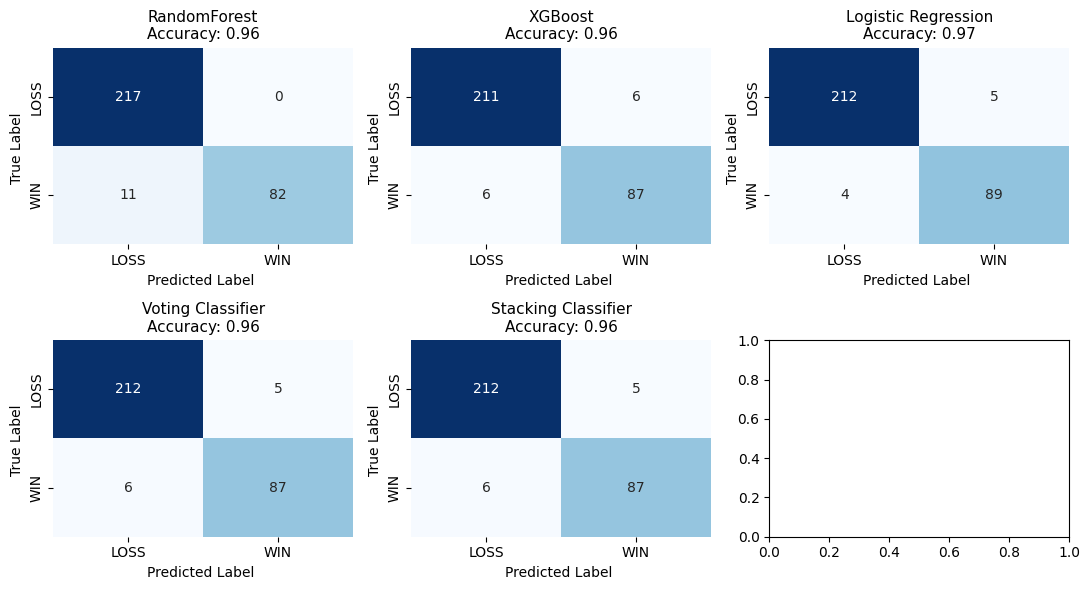

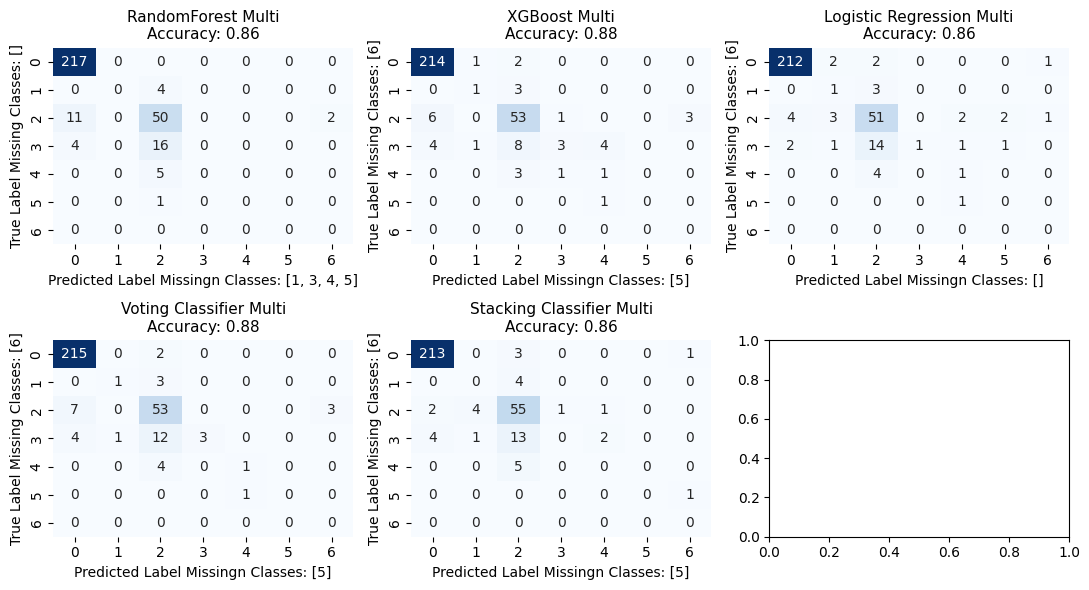

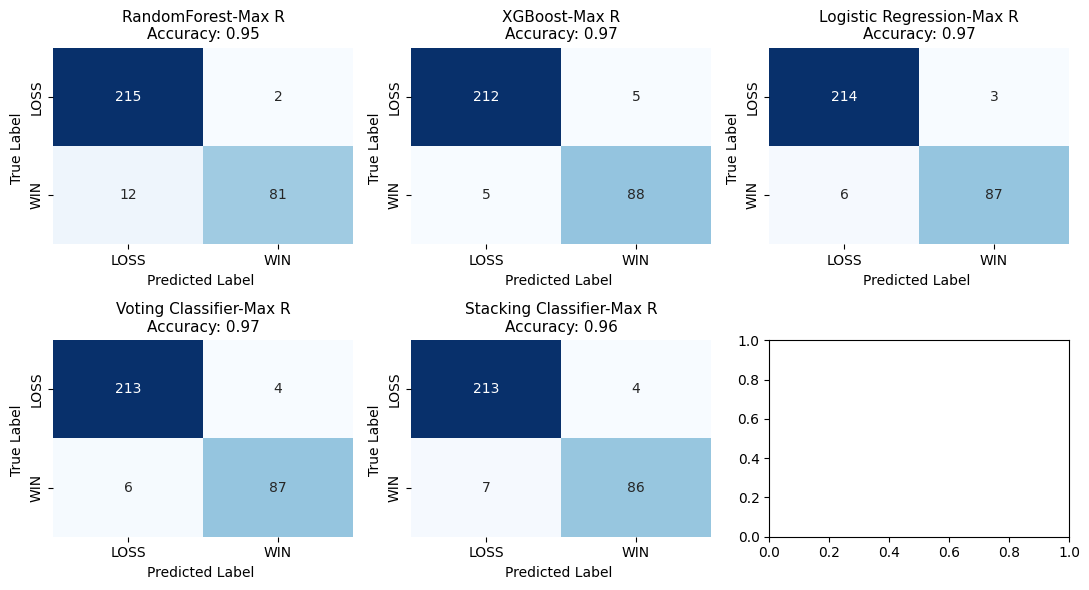

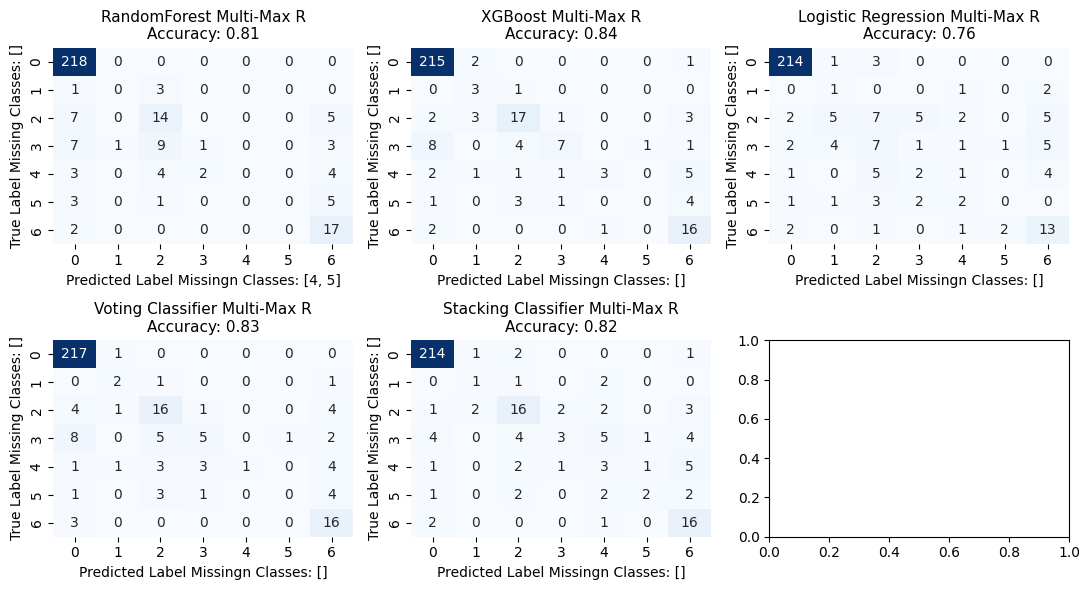

In [ ]:

# List of model names for the regular models
model_names_regular = ['RandomForest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_names_multi_regular = ['RandomForest Multi', 'XGBoost Multi', 'Logistic Regression Multi', 'Voting Classifier Multi', 'Stacking Classifier Multi']
model_names_max_r = ['RandomForest-Max R', 'XGBoost-Max R', 'Logistic Regression-Max R', 'Voting Classifier-Max R', 'Stacking Classifier-Max R']
model_names_m_max_r = ['RandomForest Multi-Max R', 'XGBoost Multi-Max R', 'Logistic Regression Multi-Max R', 'Voting Classifier Multi-Max R', 'Stacking Classifier Multi-Max R']


# Plot the confusion matrices for regular binary models
plot_confusion_matrices_horizontal(y_test, regular_binary_predictions, model_names_regular)

# Plot the confusion matrices for regular multi-class models
plot_confusion_matrices_horizontal(y_test_enc, regular_multi_predictions, model_names_multi_regular, ticks=sorted(np.unique(y_test_enc)))

# Plot the confusion matrices for Max R binary models
plot_confusion_matrices_horizontal(y_test_max_r, regular_binary_predictions_max_r, model_names_max_r)

# Plot the confusion matrices for Max R multi-class models
plot_confusion_matrices_horizontal(y_test_enc_max_r, regular_multi_predictions_max_r, model_names_m_max_r, ticks=sorted(np.unique(y_test_enc_max_r)))


#Download All Saved Files

In [ ]:
# prompt: download all files in save_models folder to my pc

from google.colab import files
import os

# Specify the directory you want to download from
directory_to_download = '/content/'

# Check if the directory exists
if os.path.exists(directory_to_download):
    # Create a zip file of the directory
    zip_filename = f"SMC_{datetime.now(timezone.utc).strftime('%m_%d_%Y')}.zip"
    !zip -r {zip_filename} {directory_to_download}

    # Download the zip file
    files.download(zip_filename)
else:
    print(f"Directory '{directory_to_download}' does not exist.")

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.06.26/ (stored 0%)
  adding: content/.config/logs/2025.06.26/13.34.57.539869.log (deflated 57%)
  adding: content/.config/logs/2025.06.26/13.34.58.222152.log (deflated 56%)
  adding: content/.config/logs/2025.06.26/13.34.38.135551.log (deflated 58%)
  adding: content/.confi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>